# ADA Final Project - Popularity of Songs with Million Songs Dataset

## 0. Preliminaries

### Libraries
Here we include all python-native and conda-bundled libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import numpy as np
import itertools
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import folium

Helper functions for our project can be found in `scripts/helpers.py`. We refactor the common functions, e.g. function to read dataset file, in order to provide reusability and to reduce redudancy in our main notebook.

In [2]:
from scripts.helpers import read_raw_dataset, read_saved_dataframe, save_dataframe, debug_dataframe, copy_dataframe
from scripts.helpers import save_map

### Datasets
We mainly use million songs datasets (msd), the msd provide two big datasets:
* msd_songs 
* msd_summary

<br>We read dataset using our predefined read_raw_dataset() function:

In [3]:
# load dataset
df_msd_songs   = read_raw_dataset("msd_songs")
df_msd_summary = read_raw_dataset("msd_summary")

Peek into the dataset using predefined debug_dataframe() function:

In [4]:
# debug dataframe msd_songs
debug_dataframe(df_msd_songs)

Dataset size:  (1000000, 11)
Dataset feature columns:  Index(['track_id', 'title', 'song_id', 'release', 'artist_id', 'artist_mbid',
       'artist_name', 'duration', 'artist_familiarity', 'artist_hotttnesss',
       'year'],
      dtype='object')

Dataset Preview:


,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year
0,TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.649822,0.394032,2003
1,TRMMMKD128F425225D,Tanssi vaan,SOVFVAK12A8C1350D9,Karkuteillä,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,156.55138,0.439604,0.356992,1995
2,TRMMMRX128F93187D9,No One Could Ever,SOGTUKN12AB017F4F1,Butter,ARGEKB01187FB50750,3d403d44-36ce-465c-ad43-ae877e65adc4,Hudson Mohawke,138.97098,0.643681,0.437504,2006


In [5]:
# debug dataframe msd_summary
debug_dataframe(df_msd_summary)

Dataset size:  (1000000, 53)
Dataset feature columns:  Index(['analysis_sample_rate', 'audio_md5', 'danceability', 'duration',
       'end_of_fade_in', 'energy', 'idx_bars_confidence', 'idx_bars_start',
       'idx_beats_confidence', 'idx_beats_start', 'idx_sections_confidence',
       'idx_sections_start', 'idx_segments_confidence',
       'idx_segments_loudness_max', 'idx_segments_loudness_max_time',
       'idx_segments_loudness_start', 'idx_segments_pitches',
       'idx_segments_start', 'idx_segments_timbre', 'idx_tatums_confidence',
       'idx_tatums_start', 'key', 'key_confidence', 'loudness', 'mode',
       'mode_confidence', 'start_of_fade_out', 'tempo', 'time_signature',
       'time_signature_confidence', 'track_id', 'analyzer_version',
       'artist_7digitalid', 'artist_familiarity', 'artist_hotttnesss',
       'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude',
       'artist_mbid', 'artist_name', 'artist_playmeid', 'genre',
       'idx_artist_terms', 

,analysis_sample_rate,audio_md5,danceability,duration,end_of_fade_in,energy,idx_bars_confidence,idx_bars_start,idx_beats_confidence,idx_beats_start,...,idx_artist_terms,idx_similar_artists,release,release_7digitalid,song_hotttnesss,song_id,title,track_7digitalid,idx_artist_mbtags,year
0,22050,aee9820911781c734e7694c5432990ca,0.0,252.05506,2.049,0.0,0,0,0,0,...,0,0,Monster Ballads X-Mas,633681,0.542899,SOQMMHC12AB0180CB8,Silent Night,7032331,0,2003
1,22050,ed222d07c83bac7689d52753610a513a,0.0,156.55138,0.258,0.0,0,0,0,0,...,0,0,Karkuteillä,145266,0.299877,SOVFVAK12A8C1350D9,Tanssi vaan,1514808,0,1995
2,22050,96c7104889a128fef84fa469d60e380c,0.0,138.97098,0.000,0.0,0,0,0,0,...,0,0,Butter,625706,0.617871,SOGTUKN12AB017F4F1,No One Could Ever,6945353,0,2006


#### Datasets observation
* Dataset consist of exactly one million datapoints.
* Column "track_id" is used as key (Primary Key) which is always unique and will be useful for join operation.
* Each datapoint (song) has 9 main attributes in msd_songs and 42 additional attributes in msd_summary. This makes all songs have 51 features (52 including track_id).
* Our projects aim to observe trend of "popular songs", therefore we will mainly work with msd_songs since msd_summary mostly contains features that we may not really need.
* Main observations of the rest of the project will most likely deal with "song_hotttnesss", as this field relates to the popularity of a song. 

## Data Preprocessing & Initial Features Analysis

From msd dataset, we get the information of exactly one million songs data with 52 columns each (track_id, song_hotttnesss, artist_hotttnesss, year, artist_id, and so on). Now for the first part, we want to investigate the attributes that lead to song popularity. We define our dataset as pairs of:

$$ (x_n, y_n) $$
where:
$$ y_n := \text{n'th song hotttnesss} $$
$$ x_n := \text{n'th vector of D features} $$
$$ D = 51 $$

First set "track_id" as index for both dataframe

In [6]:
# Set index for both dataframe
df_msd_songs   = df_msd_songs.set_index(["track_id"])
df_msd_summary = df_msd_summary.set_index(["track_id"])

Next figure out unique columns in msd_summary to avoid redundant columns when merging dataframe

In [7]:
# Use columns which are present in msd_summary but not in msd_songs
msd_summary_cols = df_msd_summary.columns.difference(df_msd_songs.columns)
len(msd_summary_cols)

42

Then we need to merge both dataframe as single df_msd based on track_id

In [8]:
# perform inner join based on index (track_id)
df_msd = pd.concat([df_msd_songs, df_msd_summary[msd_summary_cols]], axis=1, join='inner')

Debug the result

In [9]:
debug_dataframe(df_msd)

Dataset size:  (1000000, 52)
Dataset feature columns:  Index(['title', 'song_id', 'release', 'artist_id', 'artist_mbid',
       'artist_name', 'duration', 'artist_familiarity', 'artist_hotttnesss',
       'year', 'analysis_sample_rate', 'analyzer_version', 'artist_7digitalid',
       'artist_latitude', 'artist_location', 'artist_longitude',
       'artist_playmeid', 'audio_md5', 'danceability', 'end_of_fade_in',
       'energy', 'genre', 'idx_artist_mbtags', 'idx_artist_terms',
       'idx_bars_confidence', 'idx_bars_start', 'idx_beats_confidence',
       'idx_beats_start', 'idx_sections_confidence', 'idx_sections_start',
       'idx_segments_confidence', 'idx_segments_loudness_max',
       'idx_segments_loudness_max_time', 'idx_segments_loudness_start',
       'idx_segments_pitches', 'idx_segments_start', 'idx_segments_timbre',
       'idx_similar_artists', 'idx_tatums_confidence', 'idx_tatums_start',
       'key', 'key_confidence', 'loudness', 'mode', 'mode_confidence',
       'relea

,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,...,loudness,mode,mode_confidence,release_7digitalid,song_hotttnesss,start_of_fade_out,tempo,time_signature,time_signature_confidence,track_7digitalid
track_id,,,,,,,,,,,,,,,,,,,,,
TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.649822,0.394032,2003,...,-4.829,0,0.688,633681,0.542899,236.635,87.002,4,0.940,7032331
TRMMMKD128F425225D,Tanssi vaan,SOVFVAK12A8C1350D9,Karkuteillä,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,156.55138,0.439604,0.356992,1995,...,-10.555,1,0.355,145266,0.299877,148.660,150.778,1,0.000,1514808
TRMMMRX128F93187D9,No One Could Ever,SOGTUKN12AB017F4F1,Butter,ARGEKB01187FB50750,3d403d44-36ce-465c-ad43-ae877e65adc4,Hudson Mohawke,138.97098,0.643681,0.437504,2006,...,-2.060,1,0.566,625706,0.617871,138.971,177.768,4,0.446,6945353


Find and plot the correlation between features using heatmap

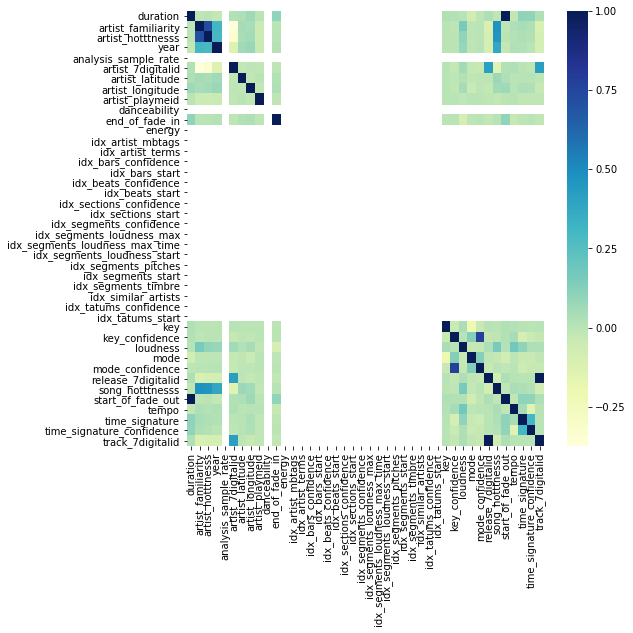

In [10]:
# Get data correlation using corr()
msd_corr = df_msd.corr()

# Plot the correlation matrix
fig, ax  = plt.subplots(figsize=(8,8))
sns.heatmap(msd_corr, 
            xticklabels=msd_corr.columns.values,
            yticklabels=msd_corr.columns.values, 
            cmap="YlGnBu",
            ax = ax)
plt.show()

#### Analyzing useless features
From above correlation chart, we can infer that some features do not give impact or relation to other attributes. Those features are: 
> ['analysis_sample_rate', 'danceability', 'energy', 'idx_bars_confidence', 'idx_bars_start',
       'idx_beats_confidence', 'idx_beats_start', 'idx_sections_confidence',
       'idx_sections_start', 'idx_segments_confidence',
       'idx_segments_loudness_max', 'idx_segments_loudness_max_time',
       'idx_segments_loudness_start', 'idx_segments_pitches',
       'idx_segments_start', 'idx_segments_timbre', 'idx_tatums_confidence',
       'idx_tatums_start', 'idx_artist_terms',
       'idx_similar_artists', 'idx_artist_mbtags']

So we then analyze if either the value of these features are unique or not. If a feature is unique for the entire datapoints, we can ignore it and drop it to narrow our analysis.

In [11]:
# List of unrelated features
unrelated_features = ['analysis_sample_rate', 'danceability','energy', 'idx_bars_confidence', 
                      'idx_bars_start', 'idx_beats_confidence', 'idx_beats_start', 'idx_sections_confidence', 
                      'idx_sections_start', 'idx_segments_confidence', 'idx_segments_loudness_max', 
                      'idx_segments_loudness_max_time', 'idx_segments_loudness_start', 'idx_segments_pitches', 
                      'idx_segments_start', 'idx_segments_timbre', 'idx_tatums_confidence', 'idx_tatums_start', 
                      'idx_artist_terms', 'idx_similar_artists', 'idx_artist_mbtags']

# define function to check unrelated features uniqueness 
def is_feature_unique(df, features):
    for feature in features:
        unique_value = df[feature].unique()
        if len(unique_value) == 1:
            print(feature + " is unique, only: " + str(unique_value[0]))

# check and print the unique features
is_feature_unique(df_msd, unrelated_features)

analysis_sample_rate is unique, only: 22050
danceability is unique, only: 0.0
energy is unique, only: 0.0
idx_bars_confidence is unique, only: 0
idx_bars_start is unique, only: 0
idx_beats_confidence is unique, only: 0
idx_beats_start is unique, only: 0
idx_sections_confidence is unique, only: 0
idx_sections_start is unique, only: 0
idx_segments_confidence is unique, only: 0
idx_segments_loudness_max is unique, only: 0
idx_segments_loudness_max_time is unique, only: 0
idx_segments_loudness_start is unique, only: 0
idx_segments_pitches is unique, only: 0
idx_segments_start is unique, only: 0
idx_segments_timbre is unique, only: 0
idx_tatums_confidence is unique, only: 0
idx_tatums_start is unique, only: 0
idx_artist_terms is unique, only: 0
idx_similar_artists is unique, only: 0
idx_artist_mbtags is unique, only: 0


#### Dropping features
From above results, we drop these features:
* 'analysis_sample_rate' 
* 'danceability'
* 'energy'
* 'idx_bars_confidence' 
* 'idx_bars_start'
* 'idx_beats_confidence'
* 'idx_beats_start'
* 'idx_sections_confidence'
* 'idx_sections_start'
* 'idx_segments_confidence'
* 'idx_segments_loudness_max'
* 'idx_segments_loudness_max_time'
* 'idx_segments_loudness_start'
* 'idx_segments_pitches'
* 'idx_segments_start'
* 'idx_segments_timbre'
* 'idx_tatums_confidence'
* 'idx_tatums_start'
* 'idx_artist_terms'
* 'idx_similar_artists'
* 'idx_artist_mbtags'

*Dropping features md5, analyzer_version, & genre*
<br>From the [dataset description](https://labrosa.ee.columbia.edu/millionsong/pages/example-track-description), we decide to drop features:
* 'audio_md5' | string | audio hash code : DROP (useless)
* 'analyzer_version' | always empty: DROP (useless)
* 'genre' | string | genre of a song, always empty : DROP (not available in msd_summary)

Note that:
* 'idx_artist_terms' can be found in msd_artist_term dataset

Thus, we drop all unrelated_features

In [12]:
df_msd = df_msd.drop(unrelated_features, axis=1)
df_msd = df_msd.drop(["audio_md5","analyzer_version","genre"], axis=1)

Replot the correlation heatmap

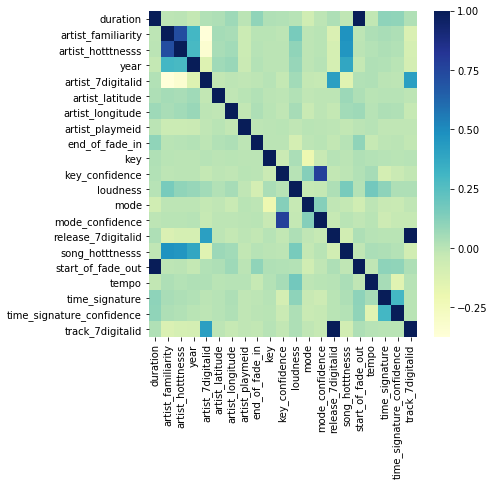

In [13]:
# Get data correlation using corr()
msd_corr = df_msd.corr()

# Plot the correlation matrix
fig, ax  = plt.subplots(figsize=(6,6))
sns.heatmap(msd_corr, 
            xticklabels=msd_corr.columns.values,
            yticklabels=msd_corr.columns.values, 
            cmap="YlGnBu",
            ax = ax)
plt.show()

See what's left on msd dataframe are:

In [14]:
debug_dataframe(df_msd)

Dataset size:  (1000000, 28)
Dataset feature columns:  Index(['title', 'song_id', 'release', 'artist_id', 'artist_mbid',
       'artist_name', 'duration', 'artist_familiarity', 'artist_hotttnesss',
       'year', 'artist_7digitalid', 'artist_latitude', 'artist_location',
       'artist_longitude', 'artist_playmeid', 'end_of_fade_in', 'key',
       'key_confidence', 'loudness', 'mode', 'mode_confidence',
       'release_7digitalid', 'song_hotttnesss', 'start_of_fade_out', 'tempo',
       'time_signature', 'time_signature_confidence', 'track_7digitalid'],
      dtype='object')

Dataset Preview:


,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,...,loudness,mode,mode_confidence,release_7digitalid,song_hotttnesss,start_of_fade_out,tempo,time_signature,time_signature_confidence,track_7digitalid
track_id,,,,,,,,,,,,,,,,,,,,,
TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.649822,0.394032,2003,...,-4.829,0,0.688,633681,0.542899,236.635,87.002,4,0.940,7032331
TRMMMKD128F425225D,Tanssi vaan,SOVFVAK12A8C1350D9,Karkuteillä,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,156.55138,0.439604,0.356992,1995,...,-10.555,1,0.355,145266,0.299877,148.660,150.778,1,0.000,1514808
TRMMMRX128F93187D9,No One Could Ever,SOGTUKN12AB017F4F1,Butter,ARGEKB01187FB50750,3d403d44-36ce-465c-ad43-ae877e65adc4,Hudson Mohawke,138.97098,0.643681,0.437504,2006,...,-2.060,1,0.566,625706,0.617871,138.971,177.768,4,0.446,6945353


At this point, we have reduced the dimension of msd datasets size from 1000000 x 52 into **1000000 x 28**

#### Handling NAN values in song_hotttnesss
*Recall that songs popularity is measured in "song_hotttnesss" column.* As we want to explore more about the correlations between other features and this value, there is no point in keeping entries which do not have this value.
<br>We inspect how many NaN values we have and then remove the all datapoints with NaN value in "song_hotttnesss".

In [15]:
NAN_entries = (df_msd.song_hotttnesss.isnull()).sum()
print("datapoints with song_hotttnesss equals to NaN: ", NAN_entries)

datapoints with song_hotttnesss equals to NaN:  418035


It's dissapointed to know that almost 50% of the datapoints have no song_hotttnesss value. Despite of that, now we remove the NAN.

In [16]:
df_msd_without_nan = df_msd[~df_msd.song_hotttnesss.isnull()]
# check how much datapoints we have
print("datapoints left: ", df_msd_without_nan.shape[0])

datapoints left:  581965


#### Save the reduced dataframe into pickle file

In [17]:
save_dataframe(df_msd_without_nan,"df_msd_reduced")

#### Load the reduced dataframe pickle file

In [18]:
# Read pickle file and form the dataframe object
df_msd_reduced = read_saved_dataframe("df_msd_reduced")
df_msd_reduced.shape

(581965, 28)

## 1. Question Block 1 : What makes song Popular?

**Recall that songs popularity is measured in "song_hotttnesss" column.** By using reduced msd dataset (with 28 columns), we can start to answer the research questions. 
<br>In addition, as we have interest with popular songs, we take only top songs based on song_hotttnesss in the last ten years  from datasets collection year (2001-2010). We also pick less popular songs (**up to 10000 songs**) to compare the data and draw valid analysis.

We define and add label based on song_hotttness as follows:
1. Popular : 
$$ song\_hotttnesss \geq 0.80 $$
2. Unpopular: 
$$ song\_hottnesss \le 0.20 $$

**Get last 10 years songs from 2001-2010.**

In [19]:
# take latest songs from 2001-2010
df_msd_latest_songs = df_msd_reduced.loc[(df_msd_reduced["year"] > 2000)]

**Get popular songs from 2001-2010.**

In [20]:
# take top songs from 2001
df_msd_top    = copy_dataframe(df_msd_latest_songs)
df_msd_top    = df_msd_top.loc[(df_msd_top["song_hotttnesss"] >= 0.8)]

# add label
df_msd_top["popularity"] = "popular"

**Get unpopular songs from 2001-2010.**
<br>We pick exactly N datapoints as the number of rows in df_msd_top.

In [22]:
# Define N
N_data = df_msd_top.shape[0]

# take unpopular songs from 2001
df_msd_less = copy_dataframe(df_msd_latest_songs)
df_msd_less = (df_msd_less.loc[(df_msd_less["song_hotttnesss"] <= 0.2)]).head(N_data)

# add label
df_msd_less["popularity"] = "unpopular"

**Merge dataframe and save the file.**

In [23]:
df_msd_1 = pd.concat([df_msd_top, df_msd_less])
save_dataframe(df_msd_1,"df_msd_1")

#### Load popular and less populars songs from (2001-2010)

In [24]:
# Read pickle file and form the dataframe object
df_msd_1 = read_saved_dataframe("df_msd_1")
print("dataset size: ", df_msd_1.shape)

dataset size:  (10736, 29)


## Q1.1 What is the characteristic/metrics of popular songs?
In this part, we want to find the features which lead to the popularity of the song. In order to find the important feature, we propose to use random forest to predict whether this song is popular/unpopular. Once we get high accuracy by random forest, we observe the attribute **feature\_importances** to see which feature matters the most. Lastly, we combine our common sense to see whether the result got from random forest is reasonable.

First let's see from numbers, which features correspond significantly to song_hotttnesss.

In [25]:
# Use corr() built-in panda to see data correlation between song_hotttnesss and others columns.
msd_corr_song_hotnes = df_msd_1.corr().loc[["song_hotttnesss"]]
display(msd_corr_song_hotnes.iloc[:,:10])
display(msd_corr_song_hotnes.iloc[:,10:])

,duration,artist_familiarity,artist_hotttnesss,year,artist_7digitalid,artist_latitude,artist_longitude,artist_playmeid,end_of_fade_in,key
song_hotttnesss,-0.03336,0.763255,0.730838,0.285594,-0.206355,0.070038,-0.047784,-0.024137,-0.001503,-0.00481


,key_confidence,loudness,mode,mode_confidence,release_7digitalid,song_hotttnesss,start_of_fade_out,tempo,time_signature,time_signature_confidence,track_7digitalid
song_hotttnesss,0.030853,0.24658,-0.021144,0.075753,-0.050971,1.0,-0.035735,0.026156,0.058583,0.069067,-0.049263


Briefly, we can see that **"artist_familiarity"** and **"artis_hotttnesss"** have strong correlations with "song_hotttness"

Next define (x,y) for RandomForestClassifier

In [35]:
unused_features = ['title', 'song_id', 'release', 'artist_id', 'artist_mbid',
                       'artist_name', 'artist_location']
unused_features.append("song_hotttnesss")
unused_features.append("popularity")

x = df_msd_1.drop(unused_features, axis=1)
y = df_msd_1.popularity

To avoid error when fitting the dataset into RandomForestClassifier, we should pay attention into NAN entries in x

In [36]:
# check if we have nan or not in x dataframe
x.isnull().values.any()

True

We simply fill the NAN in each column by the mean of the rest of data in every column

In [37]:
# fill the rest of missing values with mean
x = x.fillna(x.mean())

In [38]:
# check the data
print(x.shape)
print(y.shape)

(10736, 20)
(10736,)


In [39]:
# split the original dataset into 20% validation set, 10% test set and 80% training set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
# split the test set into 50% validation set and 50% test set (both are 10% of the original dataset)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=1)

In [40]:
# variables to store the best parameters and model
best_fscore_tr = fscore = best_fscore = best_n_estimators = best_max_depth = 0

n1 = 5
n2 = 3

n_estimators_arr = [i*100 + 1500 for i in range(n1)]
max_depth_arr = [i*10 + 20 for i in range(n2)]
fscore_test_array = np.zeros([n1,n2])
fscore_train_array = np.zeros([n1,n2])

# grid search the best parameters
for i, n_estimators in enumerate(n_estimators_arr):
    for j, max_depth in enumerate(max_depth_arr):

        # build the model and train
        clf = RandomForestClassifier(n_estimators=n_estimators, 
                                     max_depth=max_depth,
                                     n_jobs=4)
        clf.fit(x_train, y_train)

        # test the performance with validation set
        # 'macro' means calculating metrics for each label, and finding their unweighted mean
        fscore = fscore_test_array[i,j] = f1_score(y_val, clf.predict(x_val), average = 'macro')
        fscore_train_array[i,j] = f1_score(y_train, clf.predict(x_train), average = 'macro')
        
        # record the best one
        if fscore > best_fscore:
            best_fscore = fscore
            best_fscore_tr = fscore_train_array[i,j]
            best_n_estimators = n_estimators 
            best_max_depth = max_depth
            best_model = clf
            
print('best n_estimators            :', n_estimators)
print('best max_depth               :', max_depth)
print('best training f1 score       :', best_fscore_tr)
print('best validation f1 score     :', best_fscore)
print('test f1 score                :', f1_score(y_test, best_model.predict(x_test), average = 'macro'))

best n_estimators            : 1900
best max_depth               : 40
best training f1 score       : 1.0
best validation f1 score     : 0.945996275605
test f1 score                : 0.946864310346


**Confusion Matrix**
<br> visualize the performance of our model

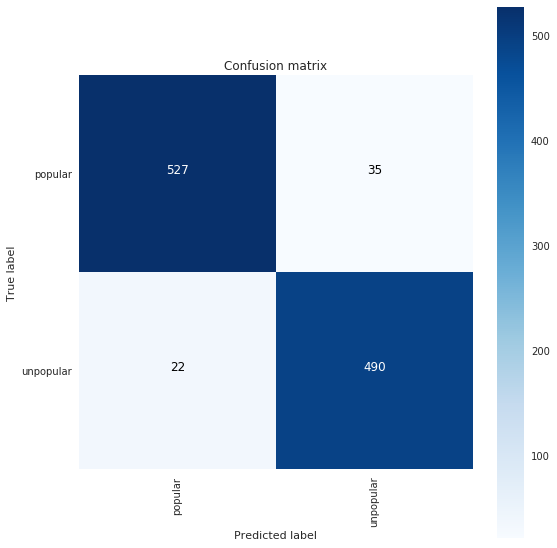

In [41]:
# create confusion matrix
sns.set(style="dark")
cnf_matrix = confusion_matrix(y_test, best_model.predict(x_test))

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """Function to plot confusion matrix
    Args:
        cm          : confusion matrix
        classes     : array storing the name of categories
        camp        : color bar of confusion matrix
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(i, j, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# plot the confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, 
                      classes=['popular', 'unpopular'],
                      title='Confusion matrix')
plt.show()

**Model Assessment**
<br>we use 10-fold cross validation to verify the performance of our model

In [42]:
def build_k_indices(y, k_fold):
    """Function to build k indices for k-fold.

    Args:
        y      (numpy array): Matrix output of size N x 1.
        k_fold (int)        : The value k, of k-fold cross validation.
        seed   (int)        : Integer value to seed the random generator.

    Returns:
        k_indices (numpy array) : Matrix of K x floor(N/K), as indices for unbiased test error of K-cross Validation.
    """
    seed = 1
    num_row    = y.shape[0]
    interval   = int(num_row / k_fold)
    np.random.seed(seed)
    indices    = np.random.permutation(num_row)
    k_indices  = np.array([indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)])
    return k_indices

def data_split(y, x, k_indices, k):
    """Function to split training data and test data using K-cross validation based on given k_indices.

    Args:
        y         (numpy array): Matrix output of size N x 1.
        tx        (numpy array): Matrix input of size N x D.
        k_indices (numpy array): Matrix of K x floor(N/K), as indices for unbiased test error of K-cross Validation.
        k         (int)        : For choosing index in the k_indices

    Returns:
        x_train (numpy array) : Matrix input (features) for training set with size of (ratio*N) x D.
        y_train (numpy array) : Matrix output for training set with size of (ratio*N) x 1.
        x_test  (numpy array) : Matrix input (features) for testing set with size of ((1-ratio)*N) x D.
        y_test  (numpy array) : Matrix output for testing set with size of ((1-ratio)*N) x 1.
    """
    
    train_set_indices               = np.ones(x.shape[0], dtype = bool)
    train_set_indices[k_indices[k]] = False

    x_train = x[train_set_indices]
    y_train = y[train_set_indices]
    
    x_test  = x.iloc[k_indices[k]]
    y_test  = y.iloc[k_indices[k]]
    
    return x_train, y_train, x_test, y_test



# build validation set
k_fold = 10
k_indices = build_k_indices(y, k_fold)

best_n_estimators = 1600
best_max_depth = 30

# best classifier from grid search
clf = RandomForestClassifier(n_estimators=best_n_estimators, 
                             max_depth=best_max_depth,
                             n_jobs=4)

accuracy_arr = np.zeros(k_fold)
para_ = []
# perform 10-fold cross validation
for k in range(k_fold):
    x_train, y_train, x_test, y_test = data_split(y = y, x = x, k_indices=k_indices, k=k)
    clf.fit(x_train, y_train)
    accuracy_arr[k] = f1_score(y_test, clf.predict(x_test), average = 'macro')
    para_.append(clf.feature_importances_)
print('average f1 score = ', np.mean(accuracy_arr))

average f1 score =  0.945807408902


**Important Features**
<br>Here we observe the distribution of feature_importance

total number of features: 20
number of features with importance 0: 0


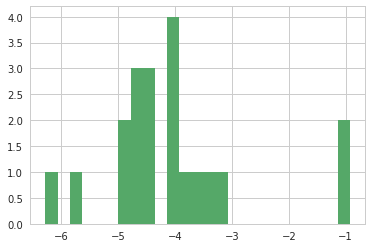

In [44]:
sns.set(style="whitegrid")
feature_importance = np.mean(para_, axis=0)

print('total number of features:', feature_importance.shape[0])
# number of 0's in the feature importance
print('number of features with importance 0:', np.sum(feature_importance == 0))

# let's see features with non-zero value in log scale
plt.hist(np.log(feature_importance[feature_importance != 0]), bins = 25)
plt.show()

We could see there're 2 features with higher importance, we print it out and find that they are artist_familiarity and artist_hotttnesss

In [45]:
print('What is the important feature for popular song (song_hotttnesss) ?')
for feature in list(x.columns[np.where(feature_importance > 0.1)]):
    print(feature)

What is the important feature for popular song (song_hotttnesss) ?
artist_familiarity
artist_hotttnesss


### Observations of Features:
> Based on result of RandomForestClassifier and Important Features, we conclude that **artist_familiarity** and **artist_hotttnesss** are the main features of popular songs.

So **popular artists** will have more chance to produce popular songs. We may have already known that people are most likely have no intention to hear the songs themselves but rather listen to songs only from his/her favorite artists.

## Q1.2 What are the challenges that music industry faces? 
#### To address this question, we will utilize more about features distribution between popular songs and less popular songs. We want to see the trend of music popularity by these.

In [46]:
df_msd_2 = copy_dataframe(df_msd_1)
df_msd_2.shape

(10736, 29)

In [47]:
df_msd_popular  = df_msd_2.loc[df_msd_2["popularity"]=="popular"]
df_msd_unpopular = df_msd_2.loc[df_msd_2["popularity"]=="unpopular"]

In [48]:
discrete_features = ['title', 'song_id', 'release', 'artist_id', 'artist_mbid',
                    'artist_name', 'artist_location']
number_features   = df_msd_2.columns.difference(discrete_features)

### Discrete Features : Release, Artist, Location

**"Release" Album**
<br>We observe how often songs in the same album become popular too.

In [54]:
# Release occurences for popular songs
df_msd_popular_release                      = copy_dataframe(df_msd_popular)
df_msd_popular_release["release_occurence"] = df_msd_popular_release \
                                                       .groupby(["release"])["release"] \
                                                       .transform('count')
# Reset the index, to later group by "release"        
df_msd_popular_release = df_msd_popular_release.reset_index()

popular_release = df_msd_popular_release[["release_occurence","release", "song_hotttnesss"]] \
                .groupby("release") \
                .agg('mean') \
                .sort_values(["release_occurence"],ascending=False)
                
popular_release.describe()

,release_occurence,song_hotttnesss
count,2407.000000,2407.000000
mean,2.230162,0.851203
std,2.355419,0.044549
min,1.000000,0.800040
25%,1.000000,0.818323
50%,1.000000,0.837882
75%,2.000000,0.870208
max,19.000000,1.000000


In [55]:
# Release occurences for unpopular songs
df_msd_unpopular_release                      = copy_dataframe(df_msd_unpopular)
df_msd_unpopular_release["release_occurence"] = df_msd_unpopular_release \
                                                       .groupby(["release"])["release"] \
                                                       .transform('count')
# Reset the index, to later group by "release"        
df_msd_unpopular_release = df_msd_unpopular_release.reset_index()

unpopular_release = df_msd_unpopular_release[["release_occurence","release", "song_hotttnesss"]] \
                .groupby("release") \
                .agg('mean') \
                .sort_values(["release_occurence"],ascending=False)
                
unpopular_release.describe()

,release_occurence,song_hotttnesss
count,3875.000000,3875.000000
mean,1.385290,0.005231
std,0.777152,0.029531
min,1.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,2.000000,0.000000
max,9.000000,0.199557


Average Top Songs occurence from same Release Album:  2.230162027420025
Median Top Songs occurence from same Release Album:  1.0
Average Unpopular Songs occurence from same Release Album:  1.3852903225806452
Median Unpopular Songs occurence from same Release Album:  1.0


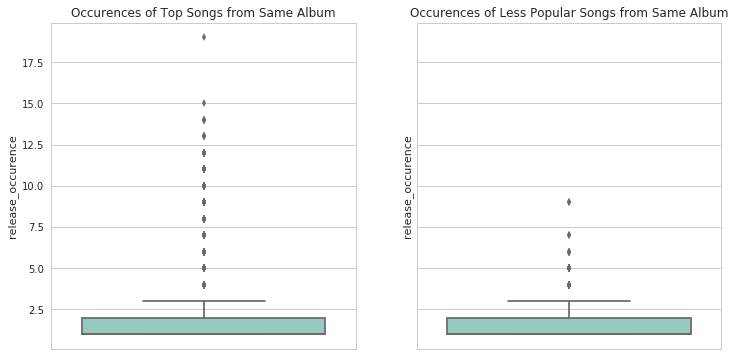

In [68]:
# Plot box plot to depict difference between popular & unpopular songs
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(12, 6)
ax1 = sns.boxplot(y = 'release_occurence' , data=popular_release, ax = ax1, palette="Set3")
ax1.set_title("Occurences of Top Songs from Same Album")

ax2 = sns.boxplot(y = 'release_occurence' , data=unpopular_release, ax = ax2, palette="Set3")
ax2.set_title("Occurences of Less Popular Songs from Same Album")

print("Average Top Songs occurence from same Release Album: ",popular_release['release_occurence'].mean())
print("Median Top Songs occurence from same Release Album: ",popular_release['release_occurence'].median())
print("Average Unpopular Songs occurence from same Release Album: ",unpopular_release['release_occurence'].mean())
print("Median Unpopular Songs occurence from same Release Album: ",unpopular_release['release_occurence'].median())

plt.show()

#### Observations of "release" features:
> We can see that there is a tiny clear distinction between popular songs and unpopular songs. In average, at least a generally popular release album has two songs in popular songs list. So basically we can say that "release" album gives little contribution into popularity of a song. But we also may see that some release album in popular songs have more than 5 of their songs on the list. The highest occurence is 19 songs coming from the same popular album.

**"Singer" or Artist**
<br>We observe how often song from same singer also become popular.

In [73]:
# Artist occurences for popular songs
df_msd_popular_artist                     = copy_dataframe(df_msd_popular)
df_msd_popular_artist["artist_occurence"] = df_msd_popular_artist \
                                                       .groupby(["artist_id"])["artist_id"] \
                                                       .transform('count')
# Reset the index, to later group by "release"        
df_msd_popular_artist = df_msd_popular_artist.reset_index()

popular_artist = df_msd_popular_artist[["artist_occurence","artist_id", "song_hotttnesss"]] \
                .groupby("artist_id") \
                .agg('mean') \
                .sort_values(["artist_occurence"],ascending=False)
                
popular_artist.describe()

,artist_occurence,song_hotttnesss
count,1232.000000,1232.000000
mean,4.357143,0.844180
std,5.406382,0.035525
min,1.000000,0.800040
25%,1.000000,0.818527
50%,2.000000,0.835998
75%,5.000000,0.862018
max,43.000000,1.000000


In [74]:
# Artist occurences for unpopular songs
df_msd_unpopular_artist                     = copy_dataframe(df_msd_unpopular)
df_msd_unpopular_artist["artist_occurence"] = df_msd_unpopular_artist \
                                                       .groupby(["artist_id"])["artist_id"] \
                                                       .transform('count')
# Reset the index, to later group by "release"        
df_msd_unpopular_artist = df_msd_unpopular_artist.reset_index()

unpopular_artist = df_msd_unpopular_artist[["artist_occurence","artist_id", "song_hotttnesss"]] \
                .groupby("artist_id") \
                .agg('mean') \
                .sort_values(["artist_occurence"],ascending=False)
                
unpopular_artist.describe()

,artist_occurence,song_hotttnesss
count,3399.000000,3399.000000
mean,1.579288,0.005344
std,1.034767,0.029214
min,1.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,2.000000,0.000000
max,11.000000,0.198813


Average Top Songs occurence from same Artist:  4.357142857142857
Median Top Songs occurence from same Artist:  2.0
Average Unpopular Songs occurence from same Artist:  1.5792880258899675
Median Unpopular Songs occurence from same Artist:  1.0


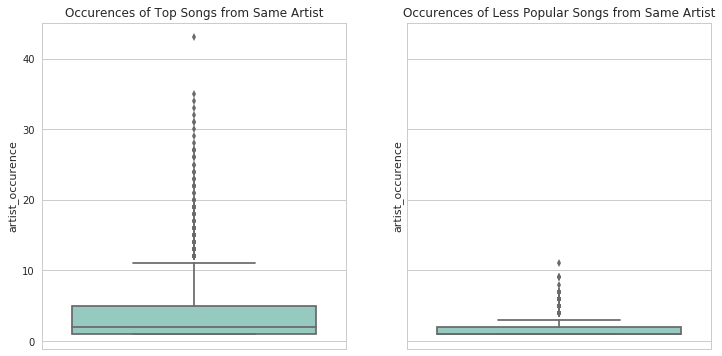

In [77]:
# Plot box plot to depict difference between popular & unpopular songs
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(12, 6)
ax1 = sns.boxplot(y = 'artist_occurence' , data=popular_artist, ax = ax1, palette="Set3")
ax1.set_title("Occurences of Top Songs from Same Artist")

ax2 = sns.boxplot(y = 'artist_occurence' , data=unpopular_artist, ax = ax2, palette="Set3")
ax2.set_title("Occurences of Less Popular Songs from Same Artist")

print("Average Top Songs occurence from same Artist: ",popular_artist['artist_occurence'].mean())
print("Median Top Songs occurence from same Artist: ",popular_artist['artist_occurence'].median())
print("Average Unpopular Songs occurence from same Artist: ",unpopular_artist['artist_occurence'].mean())
print("Median Unpopular Songs occurence from same Artist: ",unpopular_artist['artist_occurence'].median())

plt.show()

#### Observations of "artist" features:
> Compared to "release", we can observe clear relation between an "artist" to the song popularity. As we have discussed in section 1.1, we know that artist_hotttnesss and artist_familiriaty give significant correlation to the song_hotttnesss. Above, we can infer that, in average, at least 4 of popular songs are coming from the same artist. 

It is sad to know that we draw out:
> "Popular singers will be more popular as they produce new songs, unpopular singers will most likely be more unpopular and thus have no additional release"

**"Location"**
<br>We observe how songs popularity can be related with the origin region. We use folium to draw the map:

In [153]:
# Get a basic world map.
songs_map = folium.Map(location=[30, 0], tiles='CartoDB positron', zoom_start=2)

For each popular songs, give blue mark on the map

In [154]:
# Filter rows, use datapoints where artist_latitude & artist_longitude is not null
df_msd_popular_without_nan = df_msd_popular[~df_msd_popular.artist_latitude.isnull() & \
                                            ~df_msd_popular.artist_longitude.isnull()]

# Draw markers on the map.
for name, row in df_msd_popular_without_nan.iterrows():
    pop_msg = ""
    try:
        # Remove special character from a string of artist_name
        artist_name = re.sub('[^a-zA-Z0-9-_*.]', '', row["artist_name"])
        pop_msg = "Popular song by " + artist_name + " with popularity of " + str(row["song_hotttnesss"])
    except:
        pop_msg = "Popular song"
    
    folium.RegularPolygonMarker([row["artist_latitude"], row["artist_longitude"]],
                            radius=5,
                            color='#3186cc',
                            fill_color='#3186cc',
                            popup=pop_msg,
                            number_of_sides=8,
                           ).add_to(songs_map)

For each unpopular songs, give green mark on the map

In [155]:
# Filter rows, use datapoints where artist_latitude & artist_longitude is not null
df_msd_unpopular_without_nan = df_msd_unpopular[~df_msd_unpopular.artist_latitude.isnull() & \
                                                ~df_msd_unpopular.artist_longitude.isnull()]

# Draw markers on the map.
for name, row in df_msd_unpopular_without_nan.iterrows():
    pop_msg = ""
    try:
        # Remove special character from a string of artist_name
        artist_name = re.sub('[^a-zA-Z0-9-_*.]', '', row["artist_name"])
        pop_msg = "Unpopular song by " + artist_name + " with popularity of " + str(row["song_hotttnesss"])
    except:
        pop_msg = "Unpopular song"
    folium.RegularPolygonMarker([row["artist_latitude"], row["artist_longitude"]],
                                radius=5,
                                color='#2ecc71',
                                fill_color='#2ecc71',
                                popup=pop_msg,
                                number_of_sides=4,
                               ).add_to(songs_map)

Save the map

In [156]:
# Create and show the map.
save_map(songs_map,"world_songs")

Click here to view the clickable map:
> [Map](https://sanadhis.github.io/ITT-ADA-2017/project/maps/world_songs.html)

Preview Image (Not clickable). **Blue=Popular**, **Green=Unpopular**

<img src="https://sanadhis.github.io/ITT-ADA-2017/project/pictures/world_songs_map.png">

#### Observations of "location" features (latitude and longitude):
> * Overall we can spot for both popular and unpopular songs, they are mostly coming either from United States (Eastern America) of European Union (England).
> * We can conclude that the msd datasets mostly contains songs coming from United States.
> * Around EU, popular songs are mostly coming from England. 
> * In general, songs coming from non-english countries are tend to be unpopular. There is a high possibility that audiences around the world prefer to listen for songs in English. 

So, what will music industry faces?
> Urgency to use commonly and widely spoken language, English, for producing songs.

### Continous Features:

We then analyze the distribution of continuous features in our datasets

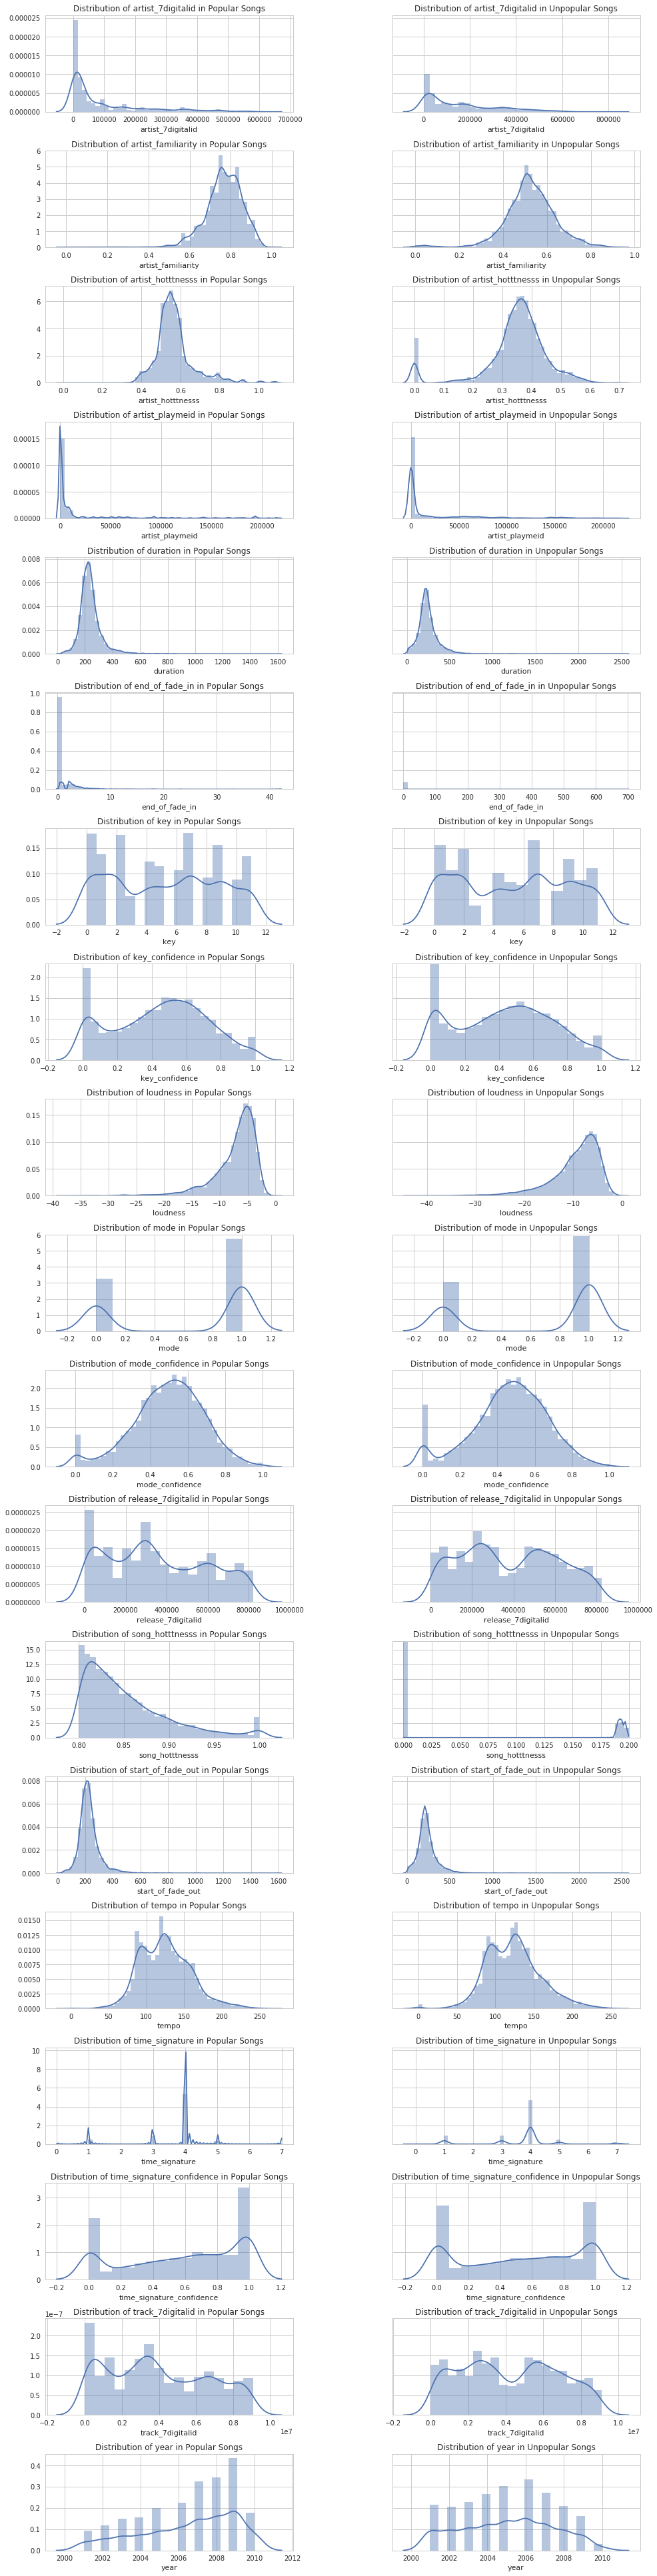

In [162]:
# We remove latitude, longitude, and popularity from number features
numerical_features = number_features.difference(["artist_latitude","artist_longitude", "popularity"])

def plot_number_features(df1, df2, features):
    """Function to plot and compare distribution of continuous features in two dataframe.
    Inputs:
        df1      (dataframe) : first dataframe
        df2      (dataframe) : second dataframe
        features (list)      : list of numerical features
    Returns:
        None
    """
    fig, axes = plt.subplots(nrows=len(features), ncols=2, sharey="row")
    fig.set_size_inches(16, 70)

    for idx, feature in enumerate(features):
        counter = 1
        for df,ax in zip([df1,df2],axes[idx]):
            title_detail = "Popular" if counter%2==1 else "Unpopular"
            counter += 1
            
            ax = sns.distplot(df[feature], ax=ax)
            ax.set_title("Distribution of " + str(feature) + " in " + title_detail + " Songs")

    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()

plot_number_features(df_msd_popular, df_msd_unpopular, numerical_features)

#### Observations of continuous features:
> * Overall we can notice that the distribution of continuous features between popular and unpopular songs are relatively same. However, we observe difference in **artist_familiarity**, **artist_hotttnesss**, **song_hotttnesss**, and **year**
> * The value distribution of artist_familiarity and artist_hotttnesss in popular songs are larger than in unpopular ones.
> * Obviously song_hotttnesss are imbalanced as we define popular songs are songs with value of song_hotttnesss larger than equal 0.80 and unpopular songs have song_hotttness less than equal 0.20
> * Popular songs mostly come from 2009 meanwhile unpopular songs mainly come from 2006.

## Q1.3 Can we analyze and predict the trend in music industry from years to years?
#### For this question, we want to find a popular term in specific year, and we try to find the story behind it. Besides, we can find the duration of popular terms and perhaps it could help us know how long these popular terms would proceed.
*Note: We will focus with popular songs (song_hotttnesss > 0.8) only for this part*

In [164]:
df_msd_3 = copy_dataframe(df_msd_1)
df_msd_3 = df_msd_3.loc[df_msd_3["popularity"]=="popular"]
df_msd_3.shape

(5368, 29)

**Recall that we will use msd_artist_term**

In [165]:
# load dataset msd_artist_term
df_msd_artist_term = read_raw_dataset("msd_artist_term")
debug_dataframe(df_msd_artist_term)

Dataset size:  (1109381, 2)
Dataset feature columns:  Index(['artist_id', 'term'], dtype='object')

Dataset Preview:


,artist_id,term
0,AR002UA1187B9A637D,garage rock
1,AR002UA1187B9A637D,country rock
2,AR002UA1187B9A637D,free jazz


Check how many unique terms we have:

In [166]:
len(df_msd_artist_term.term.unique())

7643

Perform merge based on artist_id to obtain term per track:

In [167]:
df_msd_3           = df_msd_3.reset_index()
df_msd_merged_term = pd.merge(df_msd_3, df_msd_artist_term, on=['artist_id'])

# reset index, avoid to use artist_id
df_msd_merged_term = df_msd_merged_term.reset_index()
df_msd_merged_term.shape

(117370, 32)

Now we have redundant entries in df_msd_merged_term (some tracks have more than one term).
<br>Let's see what terms have highest average song_hotttnesss

In [169]:
print("Song terms and their average song_hotttnesss:")
df_msd_merged_term.groupby(["term"])[["song_hotttnesss"]] \
                  .agg("mean") \
                  .sort_values("song_hotttnesss",ascending=False) \
                  .head(10)

Song terms and their average song_hotttnesss:


,song_hotttnesss
term,
theme song,0.987260
crossover thrash,0.970911
rio de janeiro,0.959962
singing actresses,0.958651
brazilian,0.949454
brazilian pop music,0.949454
birmingham,0.948206
outlaw country,0.944841
western swing,0.944841


In [170]:
print("Most popular songs terms within list of popular songs")
df_temp = df_msd_merged_term[["term","song_hotttnesss"]] \
                .groupby("term") \
                .agg('count') \
                .sort_values(["song_hotttnesss"],ascending=False) \
                .head(10)

df_temp.columns = ["count"]
df_temp

Most popular songs terms within list of popular songs


,count
term,
rock,4477
pop,4071
guitar,3049
indie,2932
alternative,2715
acoustic,2329
electronic,2033
indie rock,1792
punk,1781


That's it! So far, "rock" is the most popular song's theme within our scope of songs data.

But, let's observe top 10 popular terms each year.

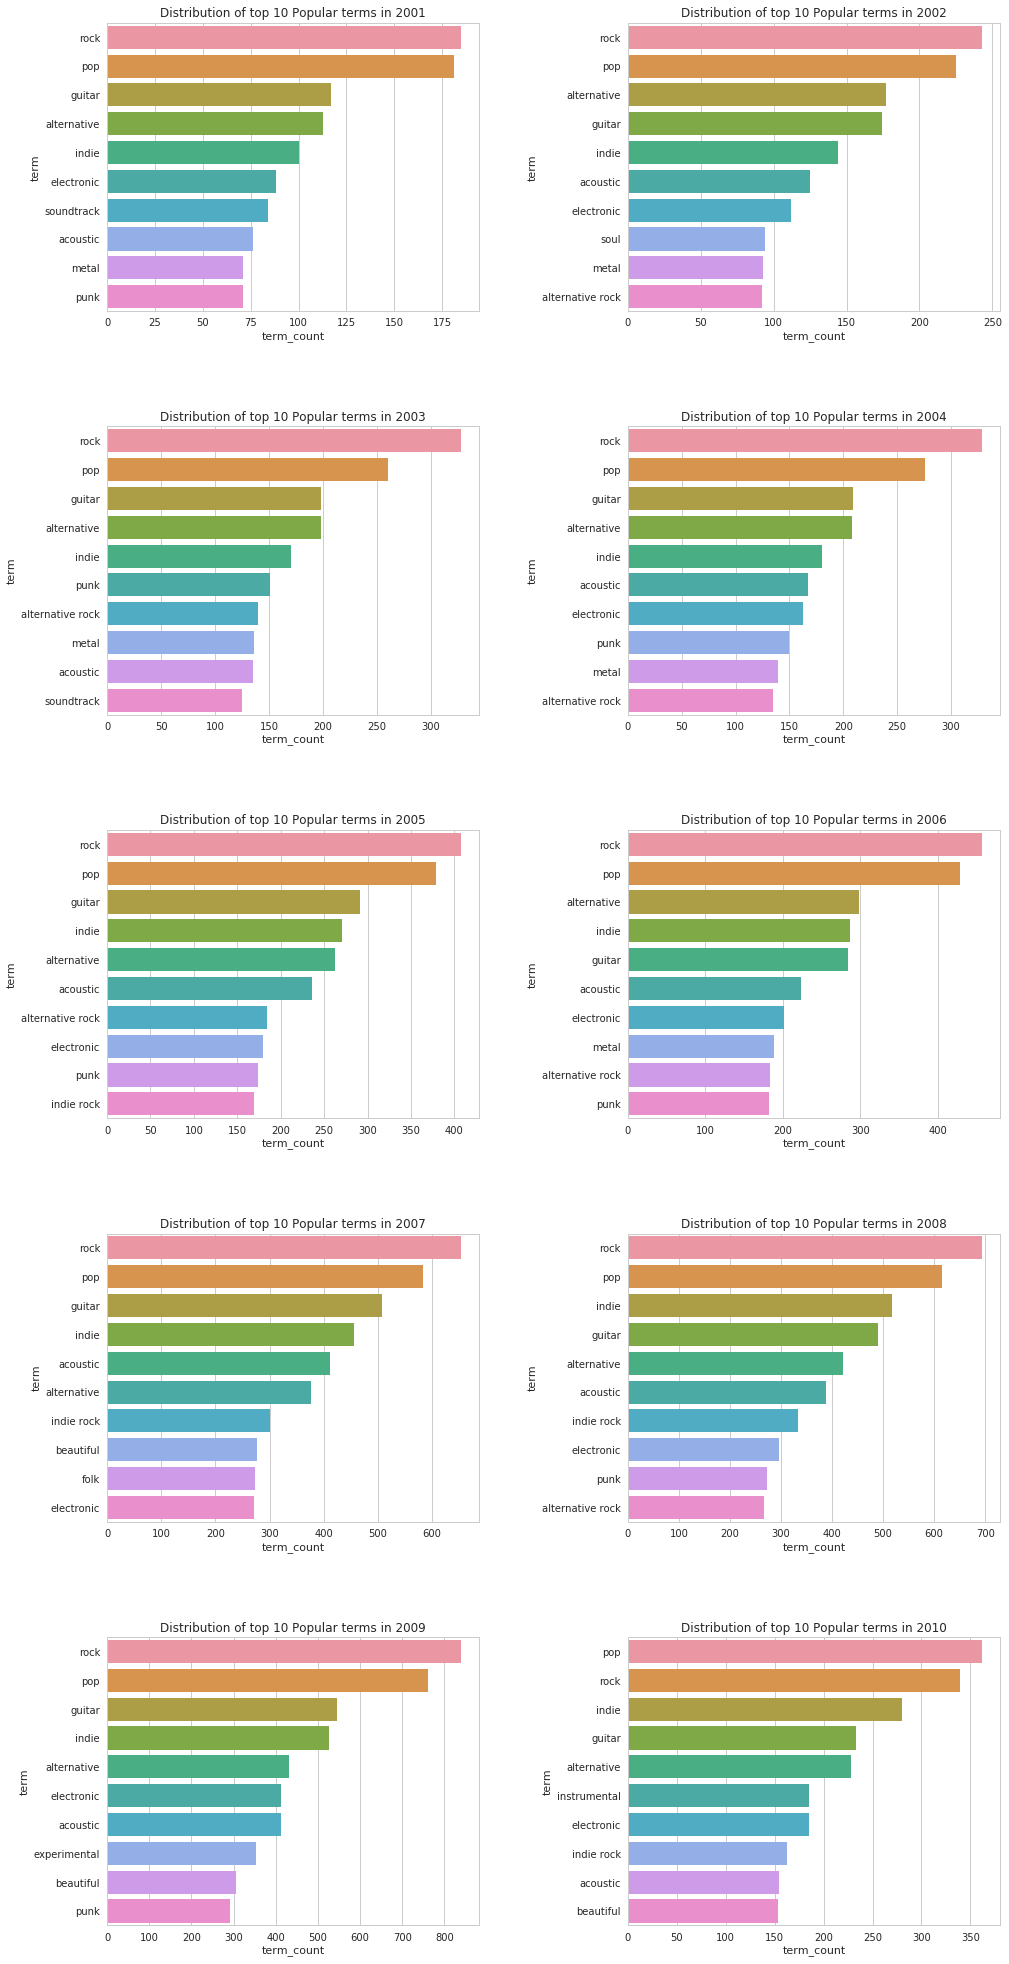

In [171]:
def plot_term_popularity_by_year(df):  
    fig, axes = plt.subplots(nrows=5, ncols=2)
    fig.set_size_inches(16, 35)
    
    for year in range(2001,2011):
        df_filter_by_year  = df[df["year"] == year]
        df_popular_by_term = df_filter_by_year[["term","song_hotttnesss"]] \
                                                .groupby("term") \
                                                .agg('count') \
                                                .sort_values(["song_hotttnesss"],ascending=False) \
                                                .head(10)
        df_popular_by_term.columns = ["term_count"]
        row    = int((year-2001)/2)
        column = int(abs((year-2000)%2-1))
        ax  = axes[row][column]
        ax  = sns.barplot(x=df_popular_by_term["term_count"], y=df_popular_by_term.index, ax=ax)
        ax.set_title("Distribution of top 10 Popular terms in " + str(year))

    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()

plot_term_popularity_by_year(df_msd_merged_term)

#### Observations of terms:
> * In conclusion, rock songs are favorite music for audiences in the first 9 years.
> * We can see that, in 2010, "Pop" becomes the top first popular genre. This indicate that music popularity is inconsistent and can change as time goes by.
> * For the last 10 years, "rock" and "pop" are absolute winner in term of audiences' choices. The difference between 2nd favorites and 3rd fav

## 2. Question Block 2 : What makes Singers Popular?

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, HTML

### Q2.1 Does the herding bias for hearing songs really happen in our society?
#### Description of question
> Herding bias means somebody would listen to several songs sung by specific singers. When we have a postive impression on the first song we hear from this singer, it's possible that we want to listen to other songs from this singer. And usually it's more likely we would love other songs from him/her, no matter whether he/she is famous.

#### Dataset

***train_triplet.txt*** - This dataset contains three features:
* User_ID: ID of users, which is used to specify different singers
* Song_ID: ID of songs, which is used to specify different songs
* Play_Count: number of times this user plays this songs

***track_unique*** - This dataset contains the mapping from song_ID to name of singer
* User_ID: ID of users, which is used to specify different singers
* singer_ID: name of singers

#### Steps
* Load the dataset into dataframe & sampling
* Quick observation of the dataset
* Map Song_ID to the singer names and observe whether there're songs from the same singer
* Define a way to measure the level of herding bias of the user
* Visualize the level of herding bias
* Observation & Comment

#### Load the dataset into dataframe & sampling
Here we have made our dataset into pickle to avoid wasting too much loading time & memory.

In [30]:
# # load data from pickle
# click_data = pickle.load(open('train_triplets', 'rb'))
# click_data.columns = ['User_ID', 'Song_ID', 'Play_Count']

# # remove the data with Play_Count = 1
# click_data = click_data[click_data['Play_Count'] != 1]


# load from pickle
click_data_group = pickle.load(open('Q2_1_raw', 'rb'))

# sampling
click_data_group = click_data_group[0:50029]

# number of people in the sample set
print('# of people we observe in our sample:', len(click_data_group.groupby('User_ID').sum()))

# of people we observe in our sample: 1022


#### Quick observation of the dataset
We can find that there's no NaN values in the dataset

In [4]:
# check the number of NaN in dataset
click_data_group.isnull().sum()

Song_ID       0
Play_Count    0
dtype: int64

In [32]:
# show how the dataframe looks like
click_data_group.head()

Song_ID  \
User_ID                                                                 
00000b722001882066dff9d2da8a775658053ea0 12098218  SOBQJJX12A6D4F7F01   
                                         12098219  SOBSSGK12A6D4F9EF1   
                                         12098220  SOCTXQW12A6D4F70AD   
                                         12098221  SOCZQCY12AC468E40F   
                                         12098222  SOFLJQZ12A6D4FADA6   

                                                   Play_Count  
User_ID                                                        
00000b722001882066dff9d2da8a775658053ea0 12098218           2  
                                         12098219           1  
                                         12098220           1  
                                         12098221           1  
                                         12098222           1

#### Map Song_ID to the singer names and observe whether there're songs from the same singer
#### Comment
Although we only show 2 users in the result below, we can already see that the 1st user listens to 2 songs from Jim Gaffigan and 2nd user listens to 2 songs from Richard Swift

In [6]:
# load the dataset to help us map 'name of singer' to 'Song_ID'
unique_tracks = pickle.load(open('./datasets/pickle_files/df_pickle_msd_unique_tracks', 'rb'))

# make a dictionary for mapping
dict_artist = unique_tracks[['song_id', 'artist_name']]
dict_artist = (dict_artist.set_index('song_id').to_dict())['artist_name']

# mapping & reorder the columns
click_data_group['Artist'] = click_data_group['Song_ID'].map(dict_artist)
click_data_group = click_data_group[['Song_ID', 'Artist', 'Play_Count']]
click_data_group.head(26)

Song_ID  \
User_ID                                                                 
00000b722001882066dff9d2da8a775658053ea0 12098218  SOBQJJX12A6D4F7F01   
                                         12098219  SOBSSGK12A6D4F9EF1   
                                         12098220  SOCTXQW12A6D4F70AD   
                                         12098221  SOCZQCY12AC468E40F   
                                         12098222  SOFLJQZ12A6D4FADA6   
                                         12098223  SOJOJUN12A8AE47E1D   
                                         12098224  SOKBXYC12A6D4F59D6   
                                         12098225  SOMRTLE12A58A78D26   
                                         12098226  SORDKNX12A8C13A45F   
                                         12098227  SOTCWRK12AB017E47D   
                                         12098228  SOTDOKZ12A8C137FCD   
                                         12098229  SOUBEXV12AB01804A4   
00001638d6189236866af9bbf309ae6c2347ffdc 33672925  SOWOTHK12A67AD818B   
                                         33672912  SOAORYL12A67AD8187   
                                         33672920  SONGKIR12A58A779D3   
                                         33672924  SOWMWVC12A67AD9795   
                                         33672918  SOLODPO12AB017F217   
                                         33672916  SOFFWTH12A6310D9E8   
                                         33672922  SOPFRAN12A8C13AA77   
                                         33672913  SOBFEDK12A8C13BB25   
                                         33672914  SOCIJBR12AB017BD92   
                                         33672915  SOEKYTM12A8C13CBF4   
                                         33672917  SOFXSRW12A6D4F3B77   
                                         33672919  SOLOYFG12A8C133391   
                                         33672921  SOOEPEG12A6D4FC7CA   
                                         33672923  SOUWYDL12A8C139BDD   

                                                                      Artist  \
User_ID                                                                        
00000b722001882066dff9d2da8a775658053ea0 12098218             Blue Man Group   
                                         12098219    John Parish / PJ Harvey   
                                         12098220  Nick Cave & The Bad Seeds   
                                         12098221               Ana Carolina   
                                         12098222                    Cartola   
                                         12098223              Edwyn Collins   
                                         12098224               Jim Gaffigan   
                                         12098225               Jim Gaffigan   
                                         12098226                      Giles   
                                         12098227                 Tab Benoit   
                                         12098228                  MC Solaar   
                                         12098229                Miley Cyrus   
00001638d6189236866af9bbf309ae6c2347ffdc 33672925              Richard Swift   
                                         33672912              Richard Swift   
                                         33672920                Sesto Sento   
                                         33672924                Billy Bragg   
                                         33672918            Essential Logic   
                                         33672916             The Beach Boys   
                                         33672922              Amel Larrieux   
                                         33672913                  Neko Case   
                                         33672914               Darude_ JS16   
                                         33672915                 Grand Funk   
                                         33672917                  Kate Bush   
                 

#### Define a way to measure the level of herding bias of the user
It's hard to say whether this person has herding bias because there's no formal definition to help us make a classification, and therefore, we decide to design a measurement, which can tell us the level of herding bias for this person: <br>
#### Defintion of level of herding bias
Consider there are $M$ data for the user, $p_m$ is Play_Count of $m$th data, and $s_m$ is the singer of $m$th data 
 
$$LevelOfHerdingBias = {{\sum{p_mu_m}}\over{\sum_{m}{p_m}}}$$

where $u_m$ is equal to 1 when $s_m$ exists more than once in $M$ data, and is equal to 0 otherwise (exists only once)<br>
The intuition of this measurment is that we want to calculate the percentage of playcounts from the songs sung by the same singer, and it's counted only if this singer exists for more than once in the user's data. The range of this measurement is from 0 to 1 because we divide the total playcounts, and hence it is safe for us to use this measurement to compare two users with different size of data.

In [7]:
# calculate score of herding bias based on the formula above
herding_bias_score = \
click_data_group.groupby('User_ID').apply(lambda t: t.Play_Count[pd.Series.duplicated(t.Artist, False)].sum()/t.Play_Count.sum())

herding_bias_score_wo_0 = herding_bias_score[herding_bias_score != 0]

#### Visualize the level of herding bias
Here, we use histogram to show the distribution of the score obtained from previous step. We provide 2 plots. The first plot is the histogram with score 0, and the second plot is the histogram without score 0. The purpose of second plot is to help us have a better understanding of distribution of other scores

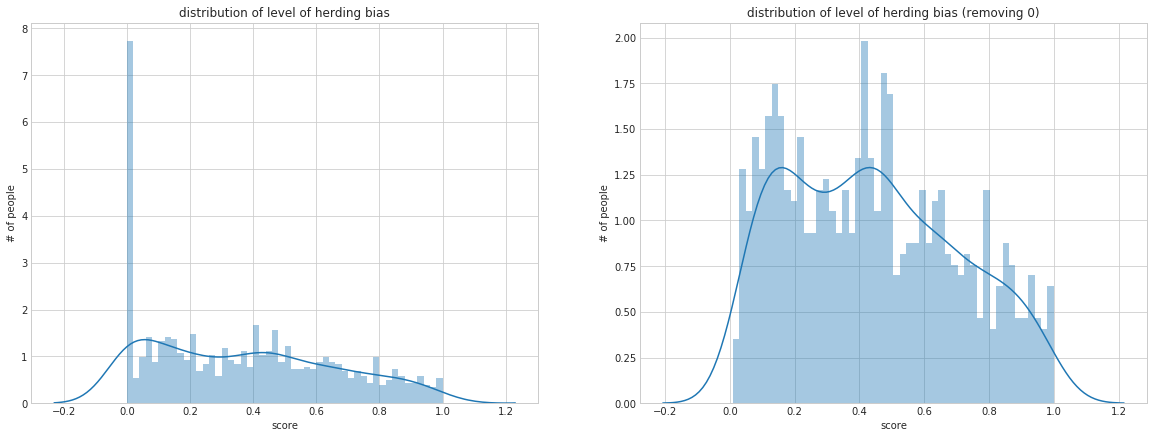

In [8]:
# set the style
sns.set_style('whitegrid')

# plot
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(20,7)
ax1 = sns.distplot(herding_bias_score, ax = ax1, bins=50)
ax1.set_xlabel('score')
ax1.set_ylabel('# of people')
ax1.set_title('distribution of level of herding bias')

ax2 = sns.distplot(herding_bias_score_wo_0, ax = ax2, bins=50)
ax2.set_xlabel('score')
ax2.set_ylabel('# of people')
ax2.set_title('distribution of level of herding bias (removing 0)')
plt.show()

Boxplot to see the properties of distribution

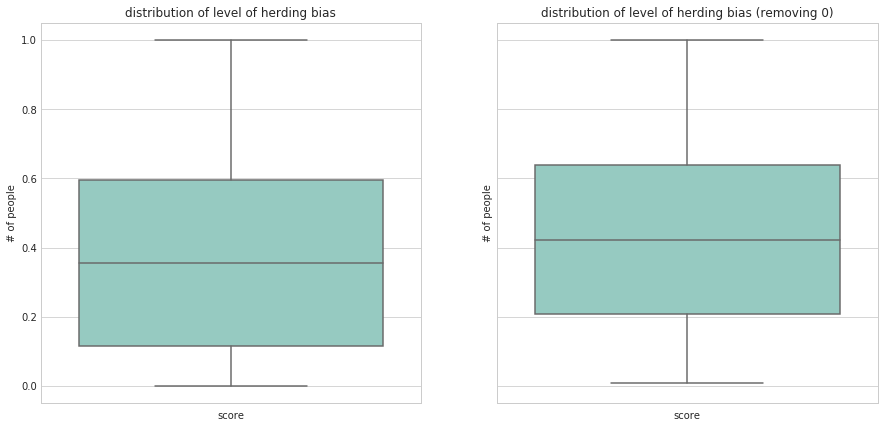

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.set_size_inches(15,7)
ax1 = sns.boxplot(y=herding_bias_score, ax = ax1, palette="Set3", showfliers=False)
ax1.set_xlabel('score')
ax1.set_ylabel('# of people')
ax1.set_title('distribution of level of herding bias')

ax2 = sns.boxplot(y=herding_bias_score_wo_0, ax = ax2, palette="Set3", showfliers=False)
ax2.set_xlabel('score')
ax2.set_ylabel('# of people')
ax2.set_title('distribution of level of herding bias (removing 0)')
plt.show()

#### Observation & Comment
From the result above, we could see nearly 160 people out of 1022 people (only 16%) have score 0, and this means that they listen to songs from different singers, and the other 84% people have more or less herding bias. We could see median value is roughly 0.38, which is not a low score in the real world. Imagine there are more than 50% of people clicking at least 38% of songs only from certain singers, this means that our listening list is somehow constrained to certain singers. <br>

-----------------
#### Investigation into the user with extreme value
However, we are afraid of and also curious about the users with the extreme values (0 and 1) because there may be some problems causing them to get this unrealistic values. Hence, we make an extention of this question to take a look at the user with score 0 and 1

#### Users with score 1
We try to see whether these people with score 1 really focus on only some specific and small number of singers

#### Comment
It turns out there's no problem for the users with score 1, the songs they listen to are sung by at most 3 singers, which means that they're really crazy for some specific singers

In [10]:
# for users with score 1
click_data_group.drop('Song_ID',1).loc[list(herding_bias_score[herding_bias_score==1].index)]\
.groupby(['User_ID','Artist']).count()

Play_Count
User_ID                                  Artist                             
0004b96b5813088cb59bfe7b06972ee8e72ef277 Asaf Avidan & the Mojos          15
                                         Red Hot Chili Peppers             4
0015f967e25f0719f45386d37f91793041c377a7 Avril Lavigne                     7
                                         Samsas Traum                      8
                                         Static-X                          5
001660e967282963ab15eea27f093c42e13a8fd1 Bethany Dillon                    6
                                         David Crowder*Band                3
                                         Shawn McDonald                    7
00166347442730d3e6c089542fac8daaa4bb5376 Florence + The Machine           14
001d50ed6ec51d2846f3372c006135def4f4bf64 Kevin Johansen                    2
                                         Orishas                          27
0029cb7955dcde8340fd85b6a9f68001cd32eb47 Gibonni                          10
                                         Parni Valjak                      6
00393e2878d1a4b8c8c9ad8ba20eae6f6cd5cf2f CSS                              11

#### Users with score 0
For users with 0, we want to make sure that the score 0 doesn't result from insufficient number of data because the fewer the data is, the more possible the score is 0. We use histogram to see the distribution of # of data.

#### Comment
We could see for each user, there're at least 10 data, which is actually an ambiguous number. It's hard to let us conclude whether this score is valid. For me I believe it's valid because I open my spotify and take a look at the songs I listen to recently, and it turns that there're 3 songs from the same singer out of 10 data, so I think it's more possible that these people don't have herding bias

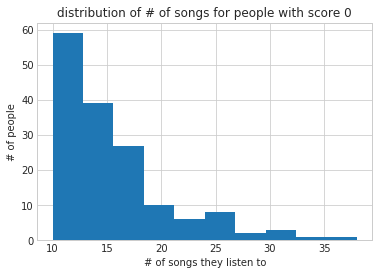

In [11]:
# for users with score 0
click_data_group.drop('Song_ID',1).loc[list(herding_bias_score[herding_bias_score==0].index)]\
.groupby('User_ID').apply(lambda t: len(t)).hist()
plt.ylabel('# of people')
plt.xlabel('# of songs they listen to')
plt.title('distribution of # of songs for people with score 0')
plt.show()

### Q2.2 Do people tend to listen to songs from popular singers?  
#### Description of question
> In other words, we want to see whether the songs sung by popular singers are usually popular.
 
#### Dataset: million song dataset
We use two features in this dataset:
* artist_name: singer name
* artist_hotttnesss: the popularity of singer
* title: song title
* song_hotttnesss: the popularity of the songs, from 0 to 1
* year: song release year

#### Steps
* Load the dataset into dataframe & data wrangling
* Choose several popular/unpopular singers and extract their songs
* Compare the song_hotttnesss of songs from popular singers and unpopular singers
* Visualize to show the difference of song_hotttnesss between popular singers and unpopular singers
* Observation & Comment <br> 


#### Load the dataset into dataframe & data wrangling
Here we have made our dataset into pickle to avoid wasting too much loading time & memory.

In [12]:
m_song =  pickle.load(open('./datasets/pickle_files/df_pickle_msd_summary', 'rb'))

# only reserve these four features
m_song = m_song[['artist_name', 'artist_hotttnesss', 'title', 'song_hotttnesss', 'year']].dropna()

# remove the song with year = 0
m_song = m_song[m_song.year != 0]

# remove the song without song_hotttnesss or song_hotttnesss = 0
m_song = m_song[~m_song.song_hotttnesss.isnull()]
m_song = m_song[m_song.song_hotttnesss != 0]


#### Observation of dataset before data wrangling
data size: (1000000,5)

| feature           | # of missing values |
|-------------------|---------------------|
| artist_name       | 0                   |
| artist_hotttnesss | 12 (=NaN)                 |
| title             | 0                   |
| song_hotttnesss   | 418035 (=NaN)             |
| year              | 484424 (=0)    |

We could see there're 41.8% of song_hotttnesss missing, but for other features, the missing values are really few
#### Observation of dataset after data wrangling
data size: (306298, 5)

| feature           | # of missing values |
|-------------------|---------------------|
| artist_name       | 0                   |
| artist_hotttnesss | 0                   |
| title             | 0                   |
| song_hotttnesss   | 0                   |
| year              | 0                   |

The size of the dataset is greatly reduced becasue of large number of missing values in song_hotttnesss, but we have no choice because song_hotttness is computed by some algorithm we don't know and this feature is the key to the solution to our question.

In [13]:
# the code used to generate the result above
# print('data size:', m_song.shape)
# print('\nNaN values statistics:')
# print(m_song.isnull().sum())


#### Choose several popular/unpopular singers and extract their songs
We only choose several popular/unpopular singers during 2005 - 2010. The way we choose popular/unpopular singers depends on the feature 'artist_hotttnesss', we analyze the popular/unpopular singer with artist_hotttnesss higher than 0.85/lower than 0.15.


In [14]:
# only consider the year >= 2005
m_song_05_10 = m_song[m_song.year >= 2005]

# only consider the singer with artist_hotttnesss >= 0.85
popular_singer = m_song_05_10[m_song_05_10.artist_hotttnesss >= 0.80]
unpopular_singer = m_song_05_10[(m_song_05_10.artist_hotttnesss > 0) & (m_song_05_10.artist_hotttnesss <= 0.20)]

m_song_05_10 = pd.concat([popular_singer, unpopular_singer])

# only consider the songs sung by one singer 
# the artist_name of the song with several singers would be like singerA/singerB/... 
token = ['/', '&', 'feat']
m_song_05_10 = m_song_05_10[[all(word not in name for word in token) for name in m_song_05_10.artist_name]]

# only consider the singer with more than 5 data
tmp = m_song_05_10.groupby('artist_name').apply(lambda t: len(t) > 5)
m_song_05_10 = m_song_05_10[[tmp[name] for name in m_song_05_10.artist_name]]

m_song_05_10.head()

,artist_name,artist_hotttnesss,title,song_hotttnesss,year
1161,Daft Punk,1.021256,Technologic (Vitalic Remix),0.599715,2005
2286,Trey Songz,0.886323,All The Ifs (Album Version),0.527703,2005
7247,Kanye West,1.082503,RoboCop,0.885513,2008
11821,Weezer,0.816313,The Damage In Your Heart,0.756422,2005
12556,T.I.,0.872839,You Ain't Missin' Nothing (Explicit Album Vers...,0.672212,2008


#### Compare the song_hotttnesss of songs from popular singers and unpopular singers
First, we show the unpopular singer name and popular name of the dataset because we need to compare them later.

In [15]:
popular_singer_name = m_song_05_10[m_song_05_10.artist_hotttnesss >= 0.80].artist_name.unique()
unpopular_singer_name = m_song_05_10[m_song_05_10.artist_hotttnesss <= 0.20].artist_name.unique()

print('popular singer:')
print(popular_singer_name)

print('\nunpopular singer:')
print(unpopular_singer_name)

popular singer:
['Daft Punk' 'Trey Songz' 'Kanye West' 'Weezer' 'T.I.' 'Rihanna' 'Eminem'
 'The Killers' 'Flo Rida' 'Black Eyed Peas' 'Katy Perry' 'Coldplay'
 'Plain White T S' 'Maroon 5' 'Lady GaGa' 'Shakira' 'Taylor Swift' 'Ke$ha'
 'Kings Of Leon' 'Usher' 'Jason Aldean' 'Carrie Underwood' 'Alicia Keys'
 "Plain White T's" 'Green Day' 'Akon' 'Bruce Springsteen']

unpopular singer:
['Stemm' 'Lee Ritenour' 'The Slickers' 'Watashi Wa' 'Liléa narrative'
 'Brandon Schott' 'La Excepcion' 'Die Unsichtbaren' 'Faith Yang'
 'Hazmat Modine' 'Ready Fire Aim' 'J-Shin' 'Dark Meat' 'Music For A While'
 'Kira Neris']


Then, we use decribe() to observe the distribution of median of song_hotttnesss for each singer. Interestingly, you could see almost all of the popular singers have higher song_hotttnesss (you could see the feature 'popular', if it's true, it means that this singer is popular)

In [36]:
stat = m_song_05_10.groupby('artist_name').song_hotttnesss.describe()[['count','50%']]
stat['popular'] = [name in popular_singer_name for name in stat.index]
stat.head(10)

,count,50%,popular
artist_name,,,
Akon,14.0,0.639138,True
Alicia Keys,6.0,0.587306,True
Black Eyed Peas,17.0,0.802500,True
Brandon Schott,9.0,0.266955,False
Bruce Springsteen,11.0,0.589946,True
Carrie Underwood,6.0,0.775219,True
Coldplay,37.0,0.786657,True
Daft Punk,24.0,0.687452,True
Dark Meat,15.0,0.358977,False


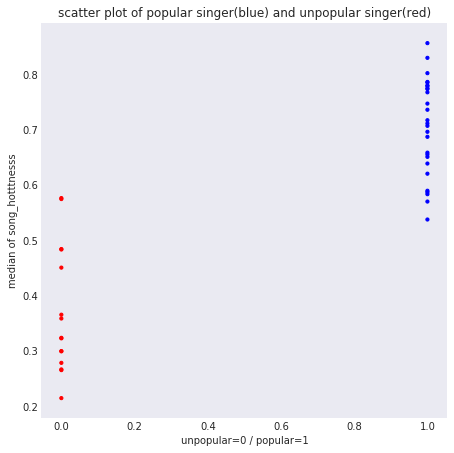

In [28]:
# show the table with scatter plot
sns.set_style('dark')
fig = plt.figure(figsize=(16,16))
ax  = fig.add_subplot(2,2,1)

colors = {True: 'blue', False: 'red'}
ax.scatter(stat['popular'], stat['50%'], \
           s=10, c=stat['popular'].apply(lambda x: colors[x]))
ax.set_ylabel('median of song_hotttnesss')
ax.set_xlabel('unpopular=0 / popular=1')
ax.set_title('scatter plot of popular singer(blue) and unpopular singer(red)')
plt.show()

#### Visualize to show the difference of song_hotttnesss between popular singers and unpopular singers
We use boxplot to plot the distribution of median values of song_hotttness for popular singer and unpopular singer

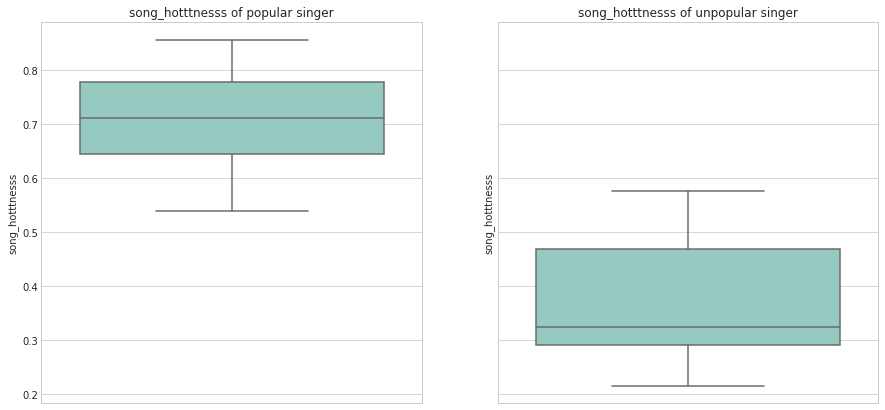

In [17]:
popular_hotttnesss = stat[[name in popular_singer_name for name in stat.index]]['50%']
unpopular_hotttnesss = stat[[name in unpopular_singer_name for name in stat.index]]['50%']

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.set_size_inches(15,7)
ax1 = sns.boxplot(y= popular_hotttnesss, ax = ax1, palette="Set3", showfliers=False)
ax1.set_ylabel('song_hotttnesss')
ax1.set_title('song_hotttnesss of popular singer')

ax2 = sns.boxplot(y=unpopular_hotttnesss, ax = ax2, palette="Set3", showfliers=False)
ax2.set_ylabel('song_hotttnesss')
ax2.set_title('song_hotttnesss of unpopular singer')
plt.show()



#### Observation & Comment 
From the result above, we could see there's a huge difference of song_hotttnesss between popular singers and unpopular singers. Therefore, the answer to "whether the hotness of a singer would directly make an influence on the hotness of their songs" is definite yes. The more popular the singer is, the more popular their song is. <br>
This phenomenon is like 'rich get richer'. We could also observe this phenomenon in real world. Just choose a popular singer in these days and check their music videos on YouTube, you would find no matter what these songs are, they usually have high click through rate.

### Q2.3 Whether the first song of the singer matters for his/her career

#### Description of question
> In this problem, we also focus on popular singers. We want to see whether the first song of this singer has some correlation with his/her career. To be more precise, we want to see whether the first song of the popular singer is usually popular, and the first songs opens his/her career. In real world, we could really find this phenomenon, for example, the korean singer psy became famous with the song 'gangnam style'.

#### Dataset: million song dataset
We use two features in this dataset:
* song_hotttnesss: the popularity of the songs
* Singer_ID: name of the singers

#### Steps
* Load the dataset into dataframe 
* Data wrangling & Choose several popular/unpopular singers and extract their songs in the first year
* See the meidan of song_hotttnesss in the 1st year of the singers
* Visualize to show the correlation
* Observation & Comment <br> 

#### Load the dataset into dataframe
In this part we also use million song dataset, but this time we are going to compare popular singers and unpopular singers during different periods: 1995-2000, 2000-2005, 2005-2010

#### Data wrangling & Choose several popular/unpopular singers and extract their songs in the first year
In this part, we also choose the popular singers with artist_hotttnesss >= 0.80 and unpopular singers with artist_hotttnesss <= 0.20 from different periods: 1995-2000, 2000-2005, 2005-2010, and we concatenate them together

In [18]:
# generate the dataframe
complete_frame = pd.DataFrame()

for year in range(1990,2010,5):
    m_song_subset = m_song[(m_song.year >= year) & (m_song.year <= year + 5)]

    popular_singer = m_song_subset[m_song_subset.artist_hotttnesss >= 0.80]
    unpopular_singer = m_song_subset[(m_song_subset.artist_hotttnesss > 0) & (m_song_subset.artist_hotttnesss <= 0.20)]

    m_song_subset = pd.concat([popular_singer, unpopular_singer])

    # only consider the songs sung by one singer 
    # the artist_name of the song with several singers would be like singerA/singerB/... 
    token = ['/', '&', 'feat']
    m_song_subset = m_song_subset[[all(word not in name for word in token) for name in m_song_subset.artist_name]]

    # only consider the singer with more than 5 data
    tmp = m_song_subset.groupby('artist_name').apply(lambda t: len(t) > 5)
    m_song_subset = m_song_subset[[tmp[name] for name in m_song_subset.artist_name]]
    
    # extract popular/unpopular singers
    popular_singer_name = m_song_subset[m_song_subset.artist_hotttnesss >= 0.80].artist_name.unique()
    unpopular_singer_name = m_song_subset[m_song_subset.artist_hotttnesss <= 0.20].artist_name.unique()

    # only consider the songs in the first year
    m_song_subset = m_song_subset.groupby('artist_name').apply(lambda t: t[t.year == min(t.year)].median())
    m_song_subset['year'] = str(year) + ' - ' + str(year + 5)
    
    # give tags of popular
    m_song_subset['popular'] = [name in popular_singer_name for name in m_song_subset.index]
    complete_frame = pd.concat([complete_frame, m_song_subset])

#### See the meidan of song_hotttnesss in the 1st year of the singers
we could see the hotness of unpopular singers' songs in first year  are usually lower than that of popular singers, which means that our guess may be right. Next, let us see the visualization

In [19]:
complete_frame.head()

,artist_hotttnesss,song_hotttnesss,year,popular
artist_name,,,,
Bruce Springsteen,0.838096,0.539222,1990 - 1995,True
Green Day,0.812308,0.737665,1990 - 1995,True
Lee Ritenour,0.144685,0.265025,1990 - 1995,False
Raging Slab,0.102711,0.400443,1990 - 1995,False
Shakira,0.804220,0.701124,1990 - 1995,True


#### Visualize to show the correlation
In this part, we use scatter plot to see whether there're obvious difference between popular singers and unpopular singers

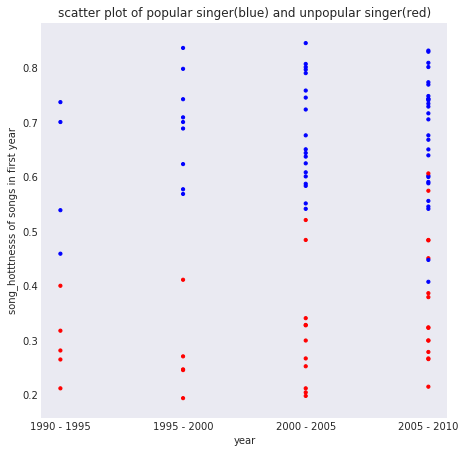

In [20]:
sns.set_style('dark')
fig = plt.figure(figsize=(16,16))
ax  = fig.add_subplot(2,2,1)

colors = {True: 'blue', False: 'red'}
ax.scatter(complete_frame['year'], complete_frame['song_hotttnesss'], \
           s=10, c=complete_frame['popular'].apply(lambda x: colors[x]))
ax.set_ylabel('song_hotttnesss of songs in first year')
ax.set_xlabel('year')
ax.set_title('scatter plot of popular singer(blue) and unpopular singer(red)')
plt.show()

#### Observation & Comment
We could see that in most cases, if the singer's songs in his/her first year are popular, then it's highly likely that he/she would be popular afterwards! And from 2010 to 2015, there're some exceptions, i.e. unpopular singers' songs are popular firstly or popular singers' songs are unpopular firstly 

### Conclusion for Q2
From Q2, we address some phenomenon about users' behavior and what may make a singer become popular, and the following is the suggestions to users and singers based on the results we got above
> For user: based on Q2.1 and Q2.2, we would suggest users to try more different songs from unpopular singers. Because of herding bias, people would tend to listen to songs from certain singers, and in Q2.2, we know songs from popular singers are usually popular. Hence, it's possible that people usually only listen to songs from popular singers

> For singer: If you want to be popular, please seize this opportunity in your first year! In Q2.3 we have already seen that most of popular singers have a success on their first album, and with the result from Q2.2: 'people tend to listen to popular singers', you should put more time on your first album because that would make your career more likely to succeed!

## 3. Question Block 3 : How's Lyrics in Popular Songs?

In [315]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scripts.helpers import read_raw_dataset, read_saved_dataframe, save_dataframe, debug_dataframe

## Q3.1 Do people care more about lyrics?

### Description :

In this question we will try to find wether people tend to listen to songs that contains certain terms or themes and if popular songs themes differ from the ones discussed in unpopular tracks.
To this end we will use the MusiXmatch dataset that is using the following format : 

Single .txt file: mxm_dataset_train.txt
      - list of top words, comma-separated
      - normal line, contains track_id, mxm track id,
        then word count for each of the top words, comma-separated
        word count is in sparse format -> ...,<word idx>:<cnt>,...
        <word idx> starts at 1 (not zero!)
            
Remember all the results and dataset are using a stemmed version of the words!

In [316]:
# load dataset
df_msd_songs   = read_raw_dataset("msd_songs")
df_msd_summary = read_raw_dataset("msd_summary")
df_mxm_lyrics = read_raw_dataset("mxm_lyrics")
df_mxm_words = read_raw_dataset("mxm_words")

We first choose to take only a subset of the songs with the highest/lowest song_hotttnesss, which is our reference for the poplarity of a song. A hotttnesss of at least 0.8 is clearly popular and one of at most 0.2 is unpopular.

In [317]:
#worst = True to take the worst songs (less hotttness)
worst = False
if(worst):
    #Here we take the worst 10000 songs sorted by hotttnesss
    df_top_songs = df_msd_summary[['song_hotttnesss', 'track_id',"title","artist_name","duration"]].sort_values('song_hotttnesss',ascending=True).loc[df_msd_summary['song_hotttnesss'] <= .2].head(10000)
else:
    #Here we take the top 2000 songs sorted by hotttnesss
    df_top_songs = df_msd_summary[['song_hotttnesss', 'track_id',"title","artist_name","duration"]].sort_values('song_hotttnesss',ascending=False).loc[df_msd_summary['song_hotttnesss'] <= 1].head(2000)
df_top_songs = df_top_songs.set_index('track_id')
df_top_songs.head()

,song_hotttnesss,title,artist_name,duration
track_id,,,,
TRYTLWJ128F1482624,1.0,The Killing Moon,Echo And The Bunnymen,347.34975
TRRVILL128F9307C9F,1.0,Panic Switch (UK edit),Silversun Pickups,253.75302
TRNSQDY128F9366831,1.0,This Is War,30 Seconds To Mars,326.97424
TRBFNSL128F42776F9,1.0,Immigrant Song (Album Version),Led Zeppelin,145.05751
TRQJUSS128E07861A6,1.0,Little Sister,Queens Of The Stone Age,211.56526


Here is an example of what the musiXmatch dataset is looking like :

In [318]:
df_mxm_lyrics.sort_values('count',ascending=False).head()

,track_id,mxm_tid,word,count,is_test
2175736,TRDIEOU128F4261A22,775220,i,1110,0
2175737,TRDIEOU128F4261A22,775220,the,1036,0
2175786,TRDIEOU128F4261A22,775220,woman,718,0
2175762,TRDIEOU128F4261A22,775220,see,700,0
2175743,TRDIEOU128F4261A22,775220,it,638,0


From this dataset we decide to remove stopwords which we consider to be uninformative (such as I, the, a...) and then get the most repeated word in every single track.

In [319]:
#We remove all lines containing stopwords
stop_wrds = open("./datasets/AdditionalFiles/stop_words.txt","r")
lines = stop_wrds.read().split('\n')
df_mxm_lyrics = df_mxm_lyrics[~df_mxm_lyrics.word.isin(lines)]
df_lyrics = df_mxm_lyrics
df_lyrics = df_lyrics.groupby('track_id')['count','word'].max()
df_lyrics.head()

,count,word
track_id,,
TRAAAAV128F421A322,2,worth
TRAAABD128F429CF47,7,yeah
TRAAAED128E0783FAB,11,whi
TRAAAEF128F4273421,17,world
TRAAAEW128F42930C0,11,wo


In [320]:
#We merge the two dataframes
df_top_songs_word = pd.merge(df_top_songs, df_lyrics, left_index=True, right_index=True, how='inner')
#get rid wrong durations some song is .7 seconds with 7 words occurences which is I think not physically possible
df_top_songs_word = df_top_songs_word[df_top_songs_word['duration'] > 1]
df_top_songs_word.head()

,song_hotttnesss,title,artist_name,duration,count,word
track_id,,,,,,
TRRVILL128F9307C9F,1.0,Panic Switch (UK edit),Silversun Pickups,253.75302,9,worth
TRNSQDY128F9366831,1.0,This Is War,30 Seconds To Mars,326.97424,22,world
TRENTGL128E0780C8E,1.0,Clocks,Coldplay,307.51302,9,want
TRIRQPO128F4281996,1.0,We Are The Sleepyheads,Belle & Sebastian,213.73342,3,whenev
TRQFXKD128E0780CAE,1.0,The Scientist,Coldplay,311.27465,17,tell


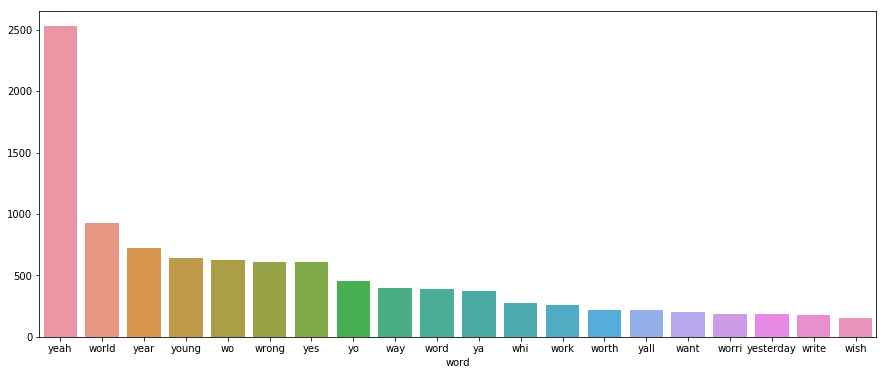

In [321]:
a = df_top_songs_word.groupby('word').sum().sort_values('count',ascending=False)[["count"]].head(20)
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
sns.barplot(a.index,list(a['count']))
plt.show()
plt.close()

The top word is by far 'Yeah' and this result is very similar for the worst songs. Hence as a first conclusion we might say people do not really care about lyrics.

Next we add weight to top words in function of occurences per duration of song to get a more precise result

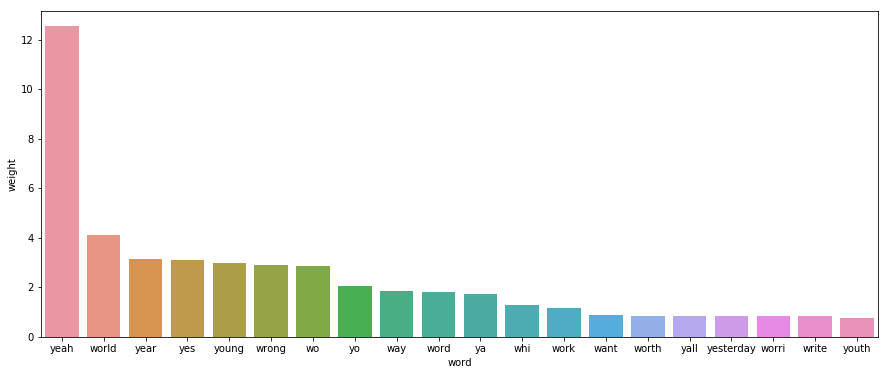

In [322]:
#weighted version
df_top_songs_word["weight"] = df_top_songs_word["count"]/df_top_songs_word["duration"]
a = df_top_songs_word.groupby('word').sum().sort_values('weight',ascending=False)[["count","weight"]].head(20)
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
sns.barplot(a.index,a.weight)
plt.show()
plt.close()

Appart from 'yeah' we can see a lot of top words concerning themes such as youth, the world/people, and verbs that refer to desire(wish, want... (woman ?)) these are similar for the worst songs as well.

Now we consider the full lyrics dataset without taking care of hotttnesss and using counting all the words for every tracks, summing them up to see what is the most reccurent theme.

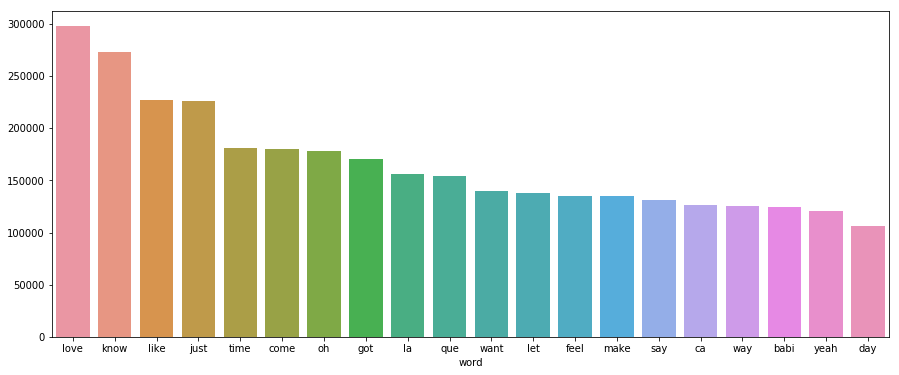

In [323]:
df_mxm_all_wrds = df_mxm_lyrics.groupby('word')['count','word'].sum()
a = df_mxm_all_wrds.sort_values('count',ascending=False).head(20)
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
sns.barplot(a.index,list(a['count']))
plt.show()
plt.close()

Here we have a different and interesting result over all the songs we can see that the most recurent word is 'love' and there are many other high-ranked words that recall feelings (feel, like, want, baby, heart, girl...).

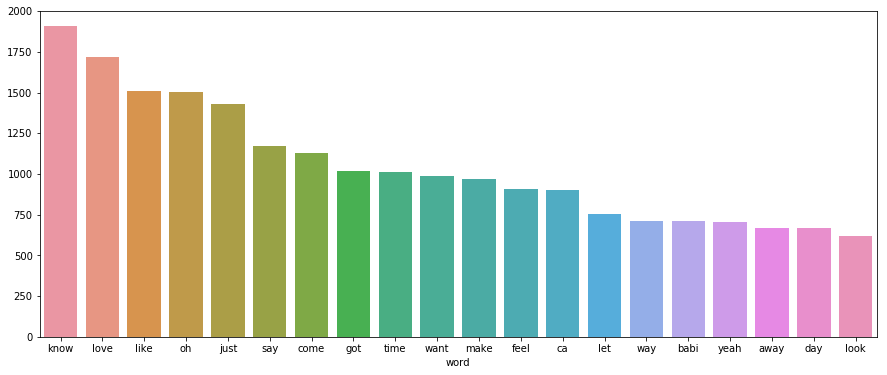

In [324]:
df_top_songs_all_wrds = pd.merge(df_top_songs, df_mxm_lyrics, left_index=True, right_on='track_id', how='inner')
df_top_songs_all_wrds = df_top_songs_all_wrds.groupby('word')['count','word'].sum()
a = df_top_songs_all_wrds.sort_values('count',ascending=False).head(20)
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
sns.barplot(a.index,list(a['count']))
plt.show()
plt.close()

We have quiet similar results for top/worst songs, in terms of lyrics we can say that top/worst songs are very similar in terms of themes addressed.

## Q3.2 Do the popular songs have the good quality of lyrics from literacy view points? Can we measure the quality and popularity of a song from its lyrics?

### Description: 

Here we will try to uncover some features that might be characteristic of popular songs, as a starting point we will focus on "slang" words such as insults or controversed subjects.


### "Slang" words part :

Here we use a text file that was used to provide an obscenity filter to find the slang words (please don't be offended by them).

In [325]:
import csv
with open('./datasets/AdditionalFiles/bad_words.csv', 'r') as f:
    reader = csv.reader(f)
    bad_words = list(reader)
bad_words = [row[1][:len(row[1])-1] for row in bad_words][4:]

In [326]:
#We retain the songs containing slang words.
df_mxm_bad = df_mxm_lyrics[df_mxm_lyrics.word.isin(bad_words)].sort_values("count",ascending = False)

In [327]:
df_bad_count = df_mxm_bad.groupby('track_id')['count','word'].sum()
df_top_bad_songs = pd.merge(df_top_songs, df_bad_count, left_index=True, right_index=True, how='inner')
print("We have a ratio of "+repr(len(df_top_bad_songs)/len(df_top_songs_word))+" top songs with bad words")
df_ratio = pd.merge(df_mxm_lyrics.groupby('track_id')['count','word'].sum(), df_top_bad_songs, left_index=True, right_index=True, how='inner')
df_ratio['ratio'] = df_ratio['count_y']/df_ratio['count_x']
df_ratio.sort_values('ratio',ascending=False)[['song_hotttnesss','title','ratio']].head()

We have a ratio of 0.3063533507397737 top songs with bad words


,song_hotttnesss,title,ratio
track_id,,,
TRQUHKZ128F930304E,0.884117,My Generation,0.214815
TROXWIE128F92D1249,0.895749,Dusk Till Dawn,0.210526
TRESXNP128EF350B90,0.899010,Fuck The Pain Away,0.198718
TRSKYDX12903CFA1D1,0.964620,Born to Party,0.194444
TRKMBDM128E0783E27,0.880696,Hollaback Girl,0.188119


We have a ratio of 0.3063533507397737 top songs with bad words. For the low hotttnesss songs we can actually see that we only have 0.22113502935420742 as a ratio. We can also see that some songs with a very high hotttness having 1/5 words being a slang word, so people might be more interested in borderline songs ?

### Lyrics density

Here we will try to see wether the sparsity of the lyrics in a songs influences its popularity (i.e. if a high density of words implies popularity).

In [328]:
df_density = df_mxm_lyrics.groupby("track_id").sum()
df_density = pd.merge(df_top_songs, df_density, left_index=True, right_index=True, how='inner')
df_density['density'] = df_density['count'] /df_density['duration']
df_density = df_density.sort_values('density',ascending = True)
df_density.head()

,song_hotttnesss,title,artist_name,duration,mxm_tid,count,is_test,density
track_id,,,,,,,,
TRNCXNX128F4282732,0.927425,Festival,Sigur Rós,565.13261,21852384,3,0,0.005308
TRLQUGG128F4261B0E,0.915077,Olsen Olsen,Sigur Ros,483.13424,4405912,6,0,0.012419
TRNKWUD128F92FEB41,0.900961,Music Is Math,Boards of Canada,321.46240,3361132,4,0,0.012443
TRWUKDU128F92E4963,0.879231,Om Nashi Me,Edward Sharpe & The Magnetic Zeros,376.05832,26090667,5,0,0.013296
TRFAOTA128E07989E0,0.940713,Heysátan,Sigur Rós,249.62567,11900784,6,0,0.024036


In [329]:
#We do this because theres a lot of wrong word count/duration
df_density= df_density.loc[df_density['density'] < 1.9]
print("On average we have "+repr(df_density['density'].mean())+" words per second for the top songs")

On average we have 0.45214054682294735 words per second for the top songs


We have 0.42832003048718376 for the worst and 0.45214054682294735 for the top the difference is quiet small and I do not think we can come to a conclusion due to the fact there might be many errors in the word counts.

As a conclusion we can say that most songs have reccurent themes (usually love and people) but these do not really influence the popularity of the song. We saw a slight trend for songs that contain slang/obscene words, they might be more popular than "polite" due to the fact they might shock the public ?
Also a song's popularity does not usually rely on the density or quality of their lyrics, as we saw in question 3.1 the most common word for the majority of the songs is 'yeah' and the lyrics sparsity isn't relevant either.

A next interesting step might by to try some natural language processing (sentiment analysis?) on the lyrics which might be difficult due to the fact we do not have complete sentences but only bag of words. 

# Next Steps

**Report & Presentations**
* We will present our report in form of datastory.

**Textual Description**
* Improve description of text and give cohesive and concise flow of our work.

**Code**
* Refactor lines of code, tidy up redundant codes, and put proper documentation.

**Results**
* Display clear results with more graphs & charts.
* Create a prediction model for song's popularity based on results 1-3.